# Anomaly Detection in Blockchain System
1. This work is aimed to enhance the working of blockchain system by automatically recognizing and filtering out anomalous activities. The targeted components of blockchain architecture are Block and Transaction for the given task. Since they are the most basic and vital aspects in the working of blockchain systems.

1. What is Anomaly Detection?
Anomaly detection is a technique used to identify unusual patterns that do not conform to expected behavior, called outliers. It has many applications in business, health monitoring, network traffic systems, etc.

1. What is the Blockchain System?
“A blockchain is a time-stamped series of an immutable record of data that is managed by a cluster of computers not owned by any single entity. Each of these blocks of data is secured and bound to each other using cryptographic principles”. In simple terms, blockchain is a chain of blocks; the words “block” and “chain” are the digital information and public database, respectively. The core components of blockchain architecture:

1. Node — user or computer within the blockchain
1. Transaction — smallest building block of a blockchain system
1. Block — a data structure used for keeping a set of transactions which is distributed to all nodes in the network
1. Chain — a sequence of blocks in a specific order
1. Miners — specific nodes which perform the block verification process
1. Consensus— a set of rules and arrangements to carry out blockchain operations
1. More information about blockchain can be found at (https://blockgeeks.com/guides/what-is-blockchain-technology/ https://www.investopedia.com/terms/b/blockchain.asp).

1. This kernel organization can be described as:
1. Importing Essential Libraries
1. Reading and Processing data
1. Model Building & Evaluation
1. Isolation Forest Algorithm
1. K Means Algorithm
1. Conclusion

In [1]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'cmpe257-376421' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

In [2]:
from google.cloud import bigquery
from scipy.stats.mstats import zscore
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib as mpl
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest 
import seaborn as sns
import datetime as dt
from datetime import datetime,tzinfo
import scipy, json, csv, time, pytz
from pytz import timezone
import numpy as np
import pandas as pd
seed = 135
%config InlineBackend.figure_format = 'retina'
%matplotlib inline


In [3]:
# The query to get date, number of transactions from Google BigQuery bitcoin blockchain dataset 
# Select records from the last three years and group them with respect to date
query_1 = """
SELECT 
   DATE(TIMESTAMP(timestamp)) AS Date,
   COUNT(transaction_count) AS Transactions
FROM `bigquery-public-data.crypto_bitcoin.blocks`
GROUP BY date
HAVING date >= '2016-01-01' AND date <= '2018-08-30'
ORDER BY date
"""
query_job_1 = client.query(query_1)
# Waits for the query to finish
iterator_1 = query_job_1.result(timeout=30)
rows_1 = list(iterator_1)
df_1 = pd.DataFrame(data=[list(x.values()) for x in rows_1], columns=list(rows_1[0].keys()))

In [4]:
# The query to get sum of all satoshis spent each day and number of blocks
query_2 = """
SELECT
  o.Date,
  COUNT(o.block) AS Blocks,
  SUM(o.output_price) AS Output_Satoshis
FROM (SELECT
    DATE(TIMESTAMP(block_timestamp)) AS Date,
    outputs[SAFE_OFFSET(0)].value AS output_price,
    block_hash AS block
  FROM
    `bigquery-public-data.crypto_bitcoin.transactions`,
    UNNEST(outputs) AS output ) as o
GROUP BY
  o.date
HAVING o.date >= '2016-01-01' AND date <= '2018-08-30'
ORDER BY o.date, blocks
"""
query_job_2 = client.query(query_2)
# Waits for the query to finish
iterator_2 = query_job_2.result(timeout=30)
rows_2 = list(iterator_2)
df_2 = pd.DataFrame(data=[list(x.values()) for x in rows_2], columns=list(rows_2[0].keys()))

df_2["Output_Satoshis"]= df_2["Output_Satoshis"].apply(lambda x: float(x/100000000))

In [5]:
df_1.head()

Date  Transactions
0  2016-01-01           135
1  2016-01-02           145
2  2016-01-03           145
3  2016-01-04           181
4  2016-01-05           157

In [6]:
df_2.head()

Date  Blocks  Output_Satoshis
0  2016-01-01  361519     1.470216e+06
1  2016-01-02  455120     9.884226e+05
2  2016-01-03  478708     1.031215e+06
3  2016-01-04  492865     1.215813e+06
4  2016-01-05  506371     1.712227e+06

In [7]:
# merge the two dataframes
result = pd.merge(df_1,
                 df_2[['Date', 'Blocks', 'Output_Satoshis']],
                 on='Date')
result.head()

Date  Transactions  Blocks  Output_Satoshis
0  2016-01-01           135  361519     1.470216e+06
1  2016-01-02           145  455120     9.884226e+05
2  2016-01-03           145  478708     1.031215e+06
3  2016-01-04           181  492865     1.215813e+06
4  2016-01-05           157  506371     1.712227e+06

In [8]:
# Number of records 
len(result)

973

In [9]:
# get the overview of our data
result.describe()

Transactions        Blocks  Output_Satoshis
count    973.000000  9.730000e+02     9.730000e+02
mean     152.188078  6.377588e+05     1.916529e+06
std       16.029441  1.345307e+05     2.787127e+06
min       80.000000  3.524240e+05     4.437819e+05
25%      142.000000  5.481570e+05     1.031215e+06
50%      152.000000  6.074250e+05     1.498388e+06
75%      163.000000  7.026960e+05     2.134859e+06
max      200.000000  1.264802e+06     6.813039e+07

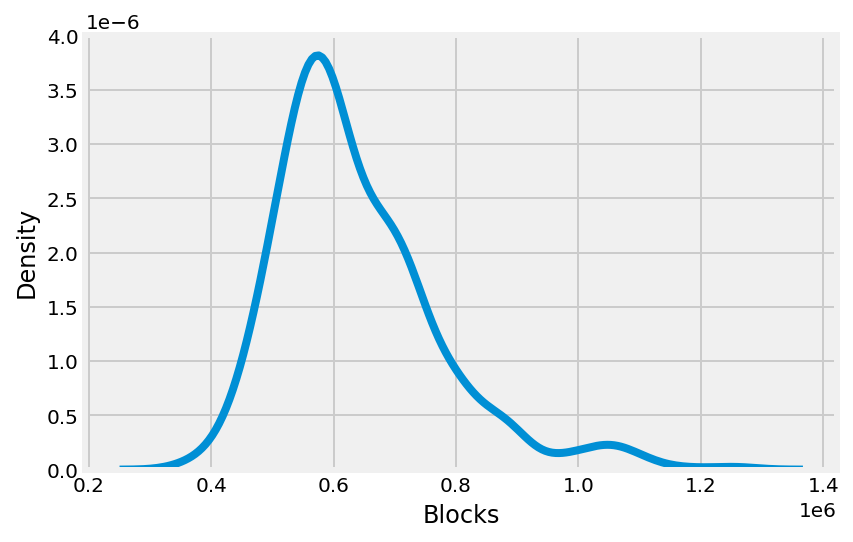

In [10]:
sns.kdeplot(result['Blocks'])

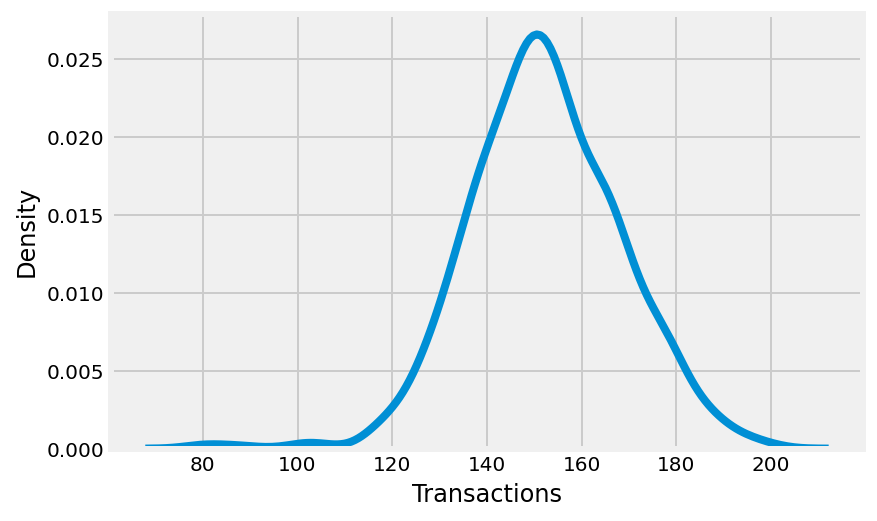

In [11]:
sns.kdeplot(result['Transactions'])

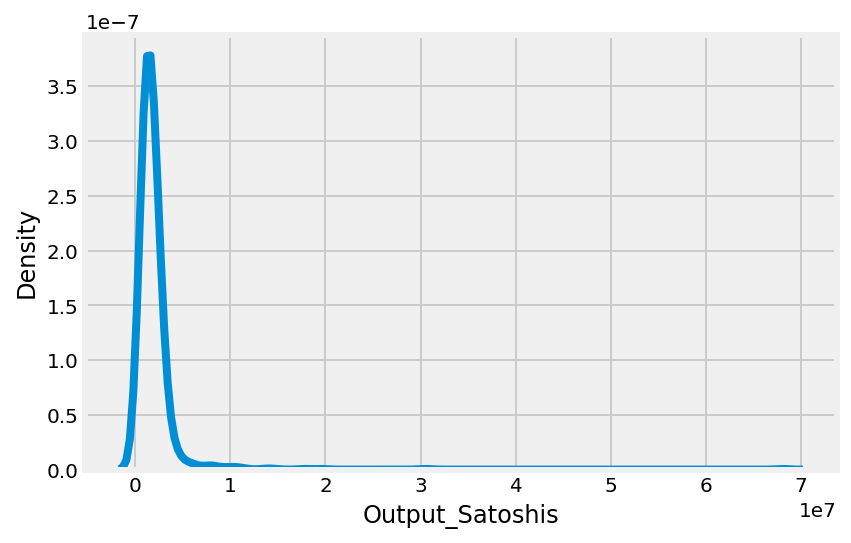

In [12]:

sns.kdeplot(result['Output_Satoshis'])

Great, mostly the features of data are following the bell-shaped curve. Now, let's plot the curves of three vital features (Transactions, Blocks, Output Satoshis) of our data with respect to the date. Is there some trend in these plots?

Text(0.5, 1.0, 'Transactions per day')

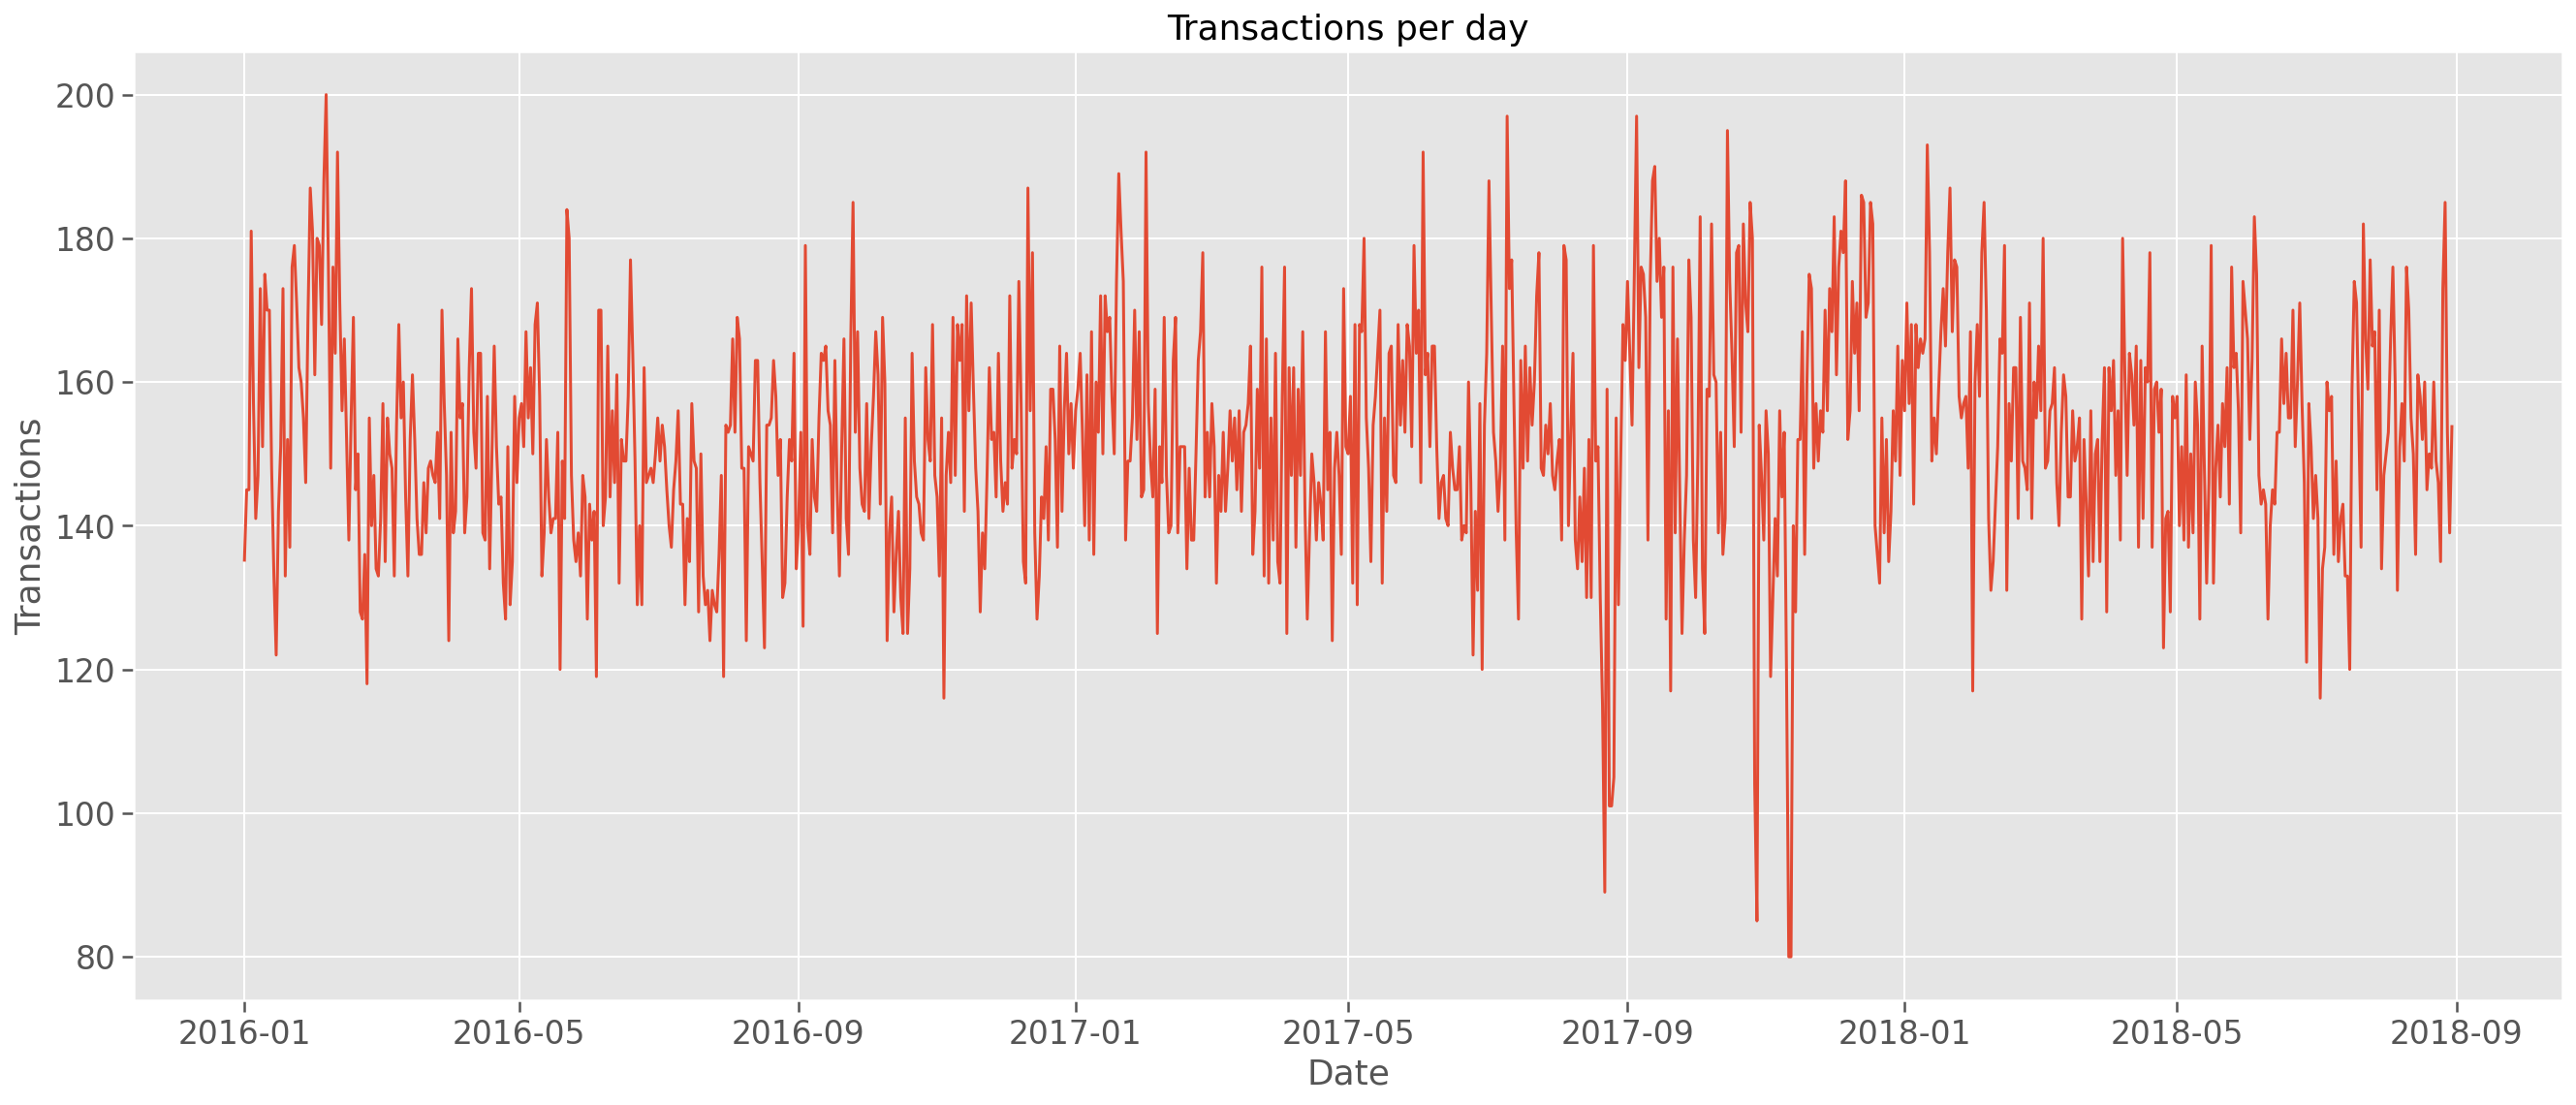

In [13]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='Date', y='Transactions', data=result, palette='Blues_d')
plt.title('Transactions per day')

Text(0.5, 1.0, 'Blocks per day')

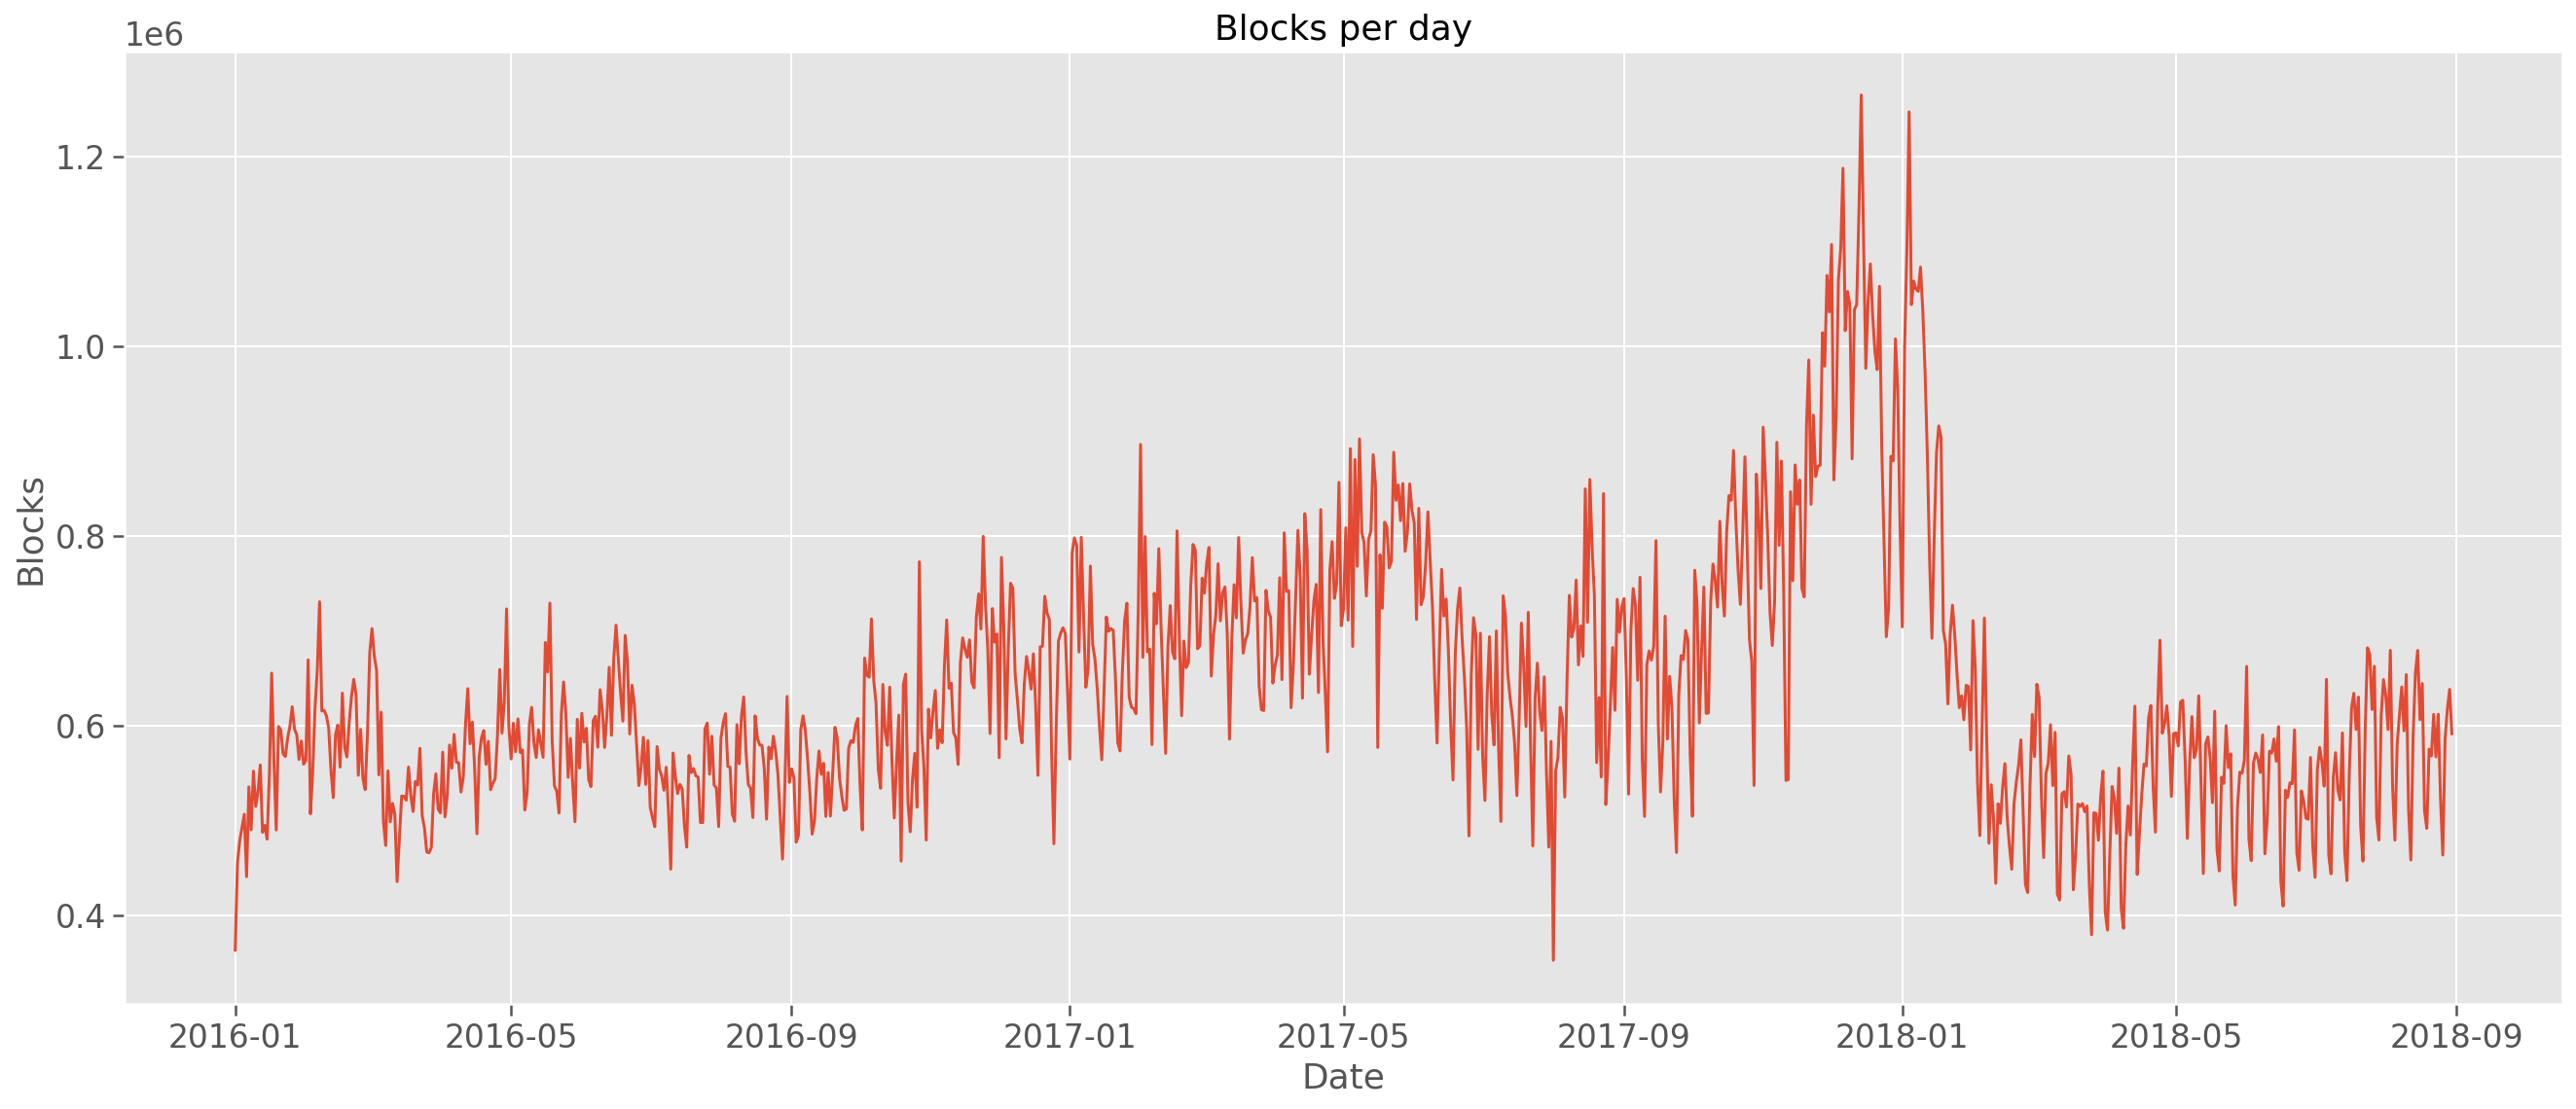

In [14]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='Date', y='Blocks', data=result, palette='Blues_d')
plt.title('Blocks per day')

Text(0.5, 1.0, 'Sum of all satoshis spent each day')

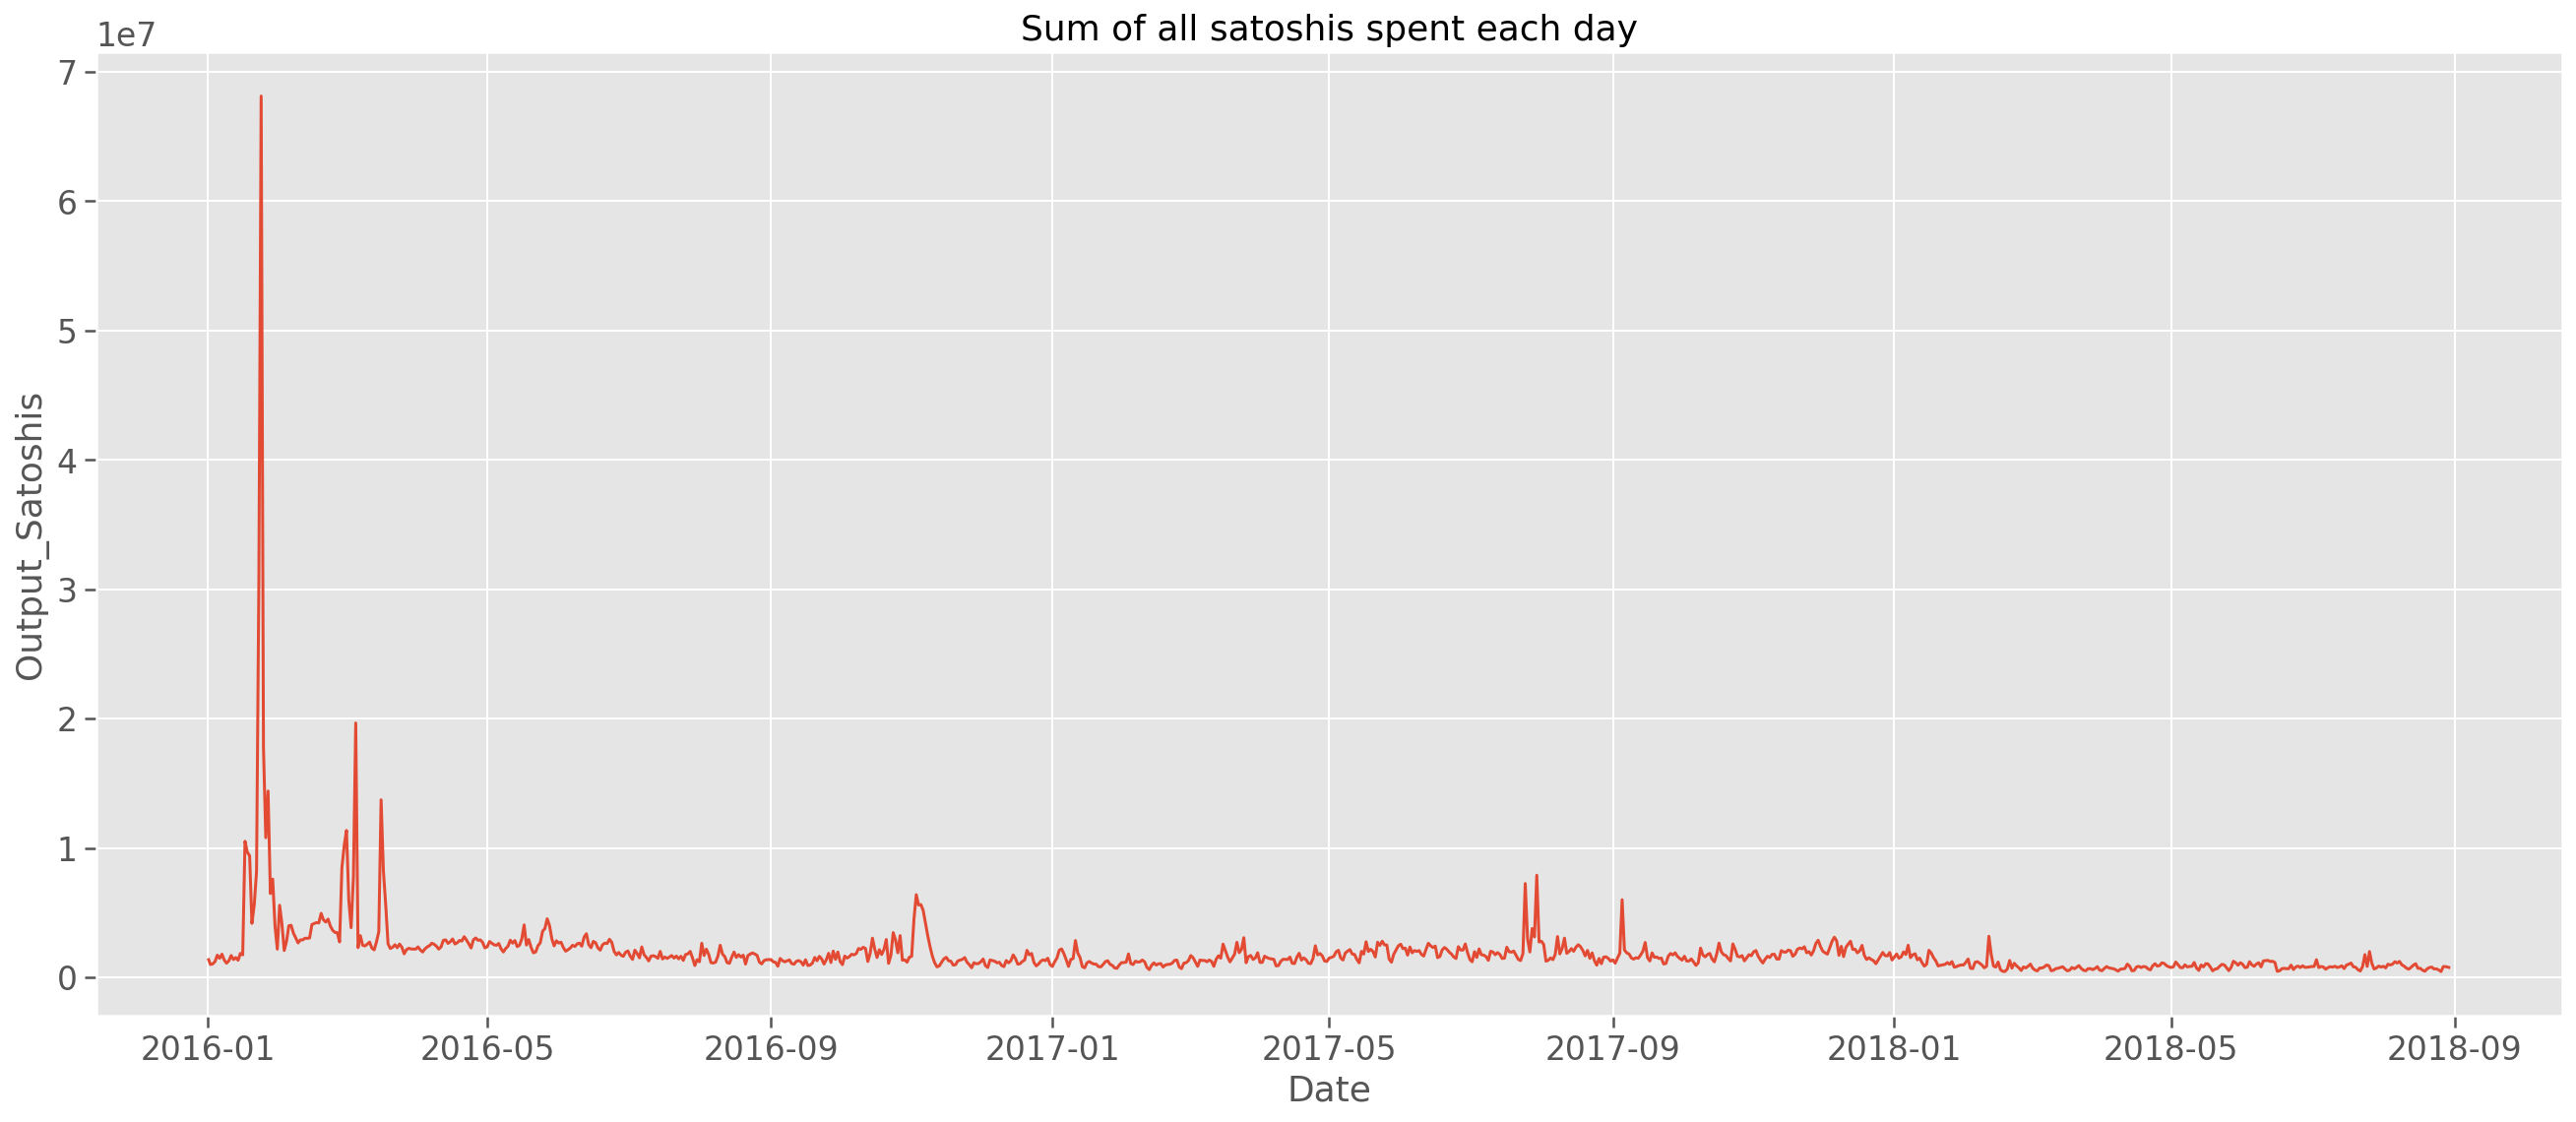

In [15]:
g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='Date', y='Output_Satoshis', data=result, palette='BuGn_r')
plt.title('Sum of all satoshis spent each day')

So we should now get back to the previous question. Is there some trend here in the graphs? The possible answer can be not exactly. So why did we plot those curves? Often, In anomaly detection, we make use of different algorithms to determine the anomalies in the data. Mostly unsupervised learning-based anomaly detection algorithm uses outliers to detect anomalies. Yes, we will evaluate these outliers employing several anomaly detection algorithms in this notebook and will get back to these curves again at last to determine the anomalies.

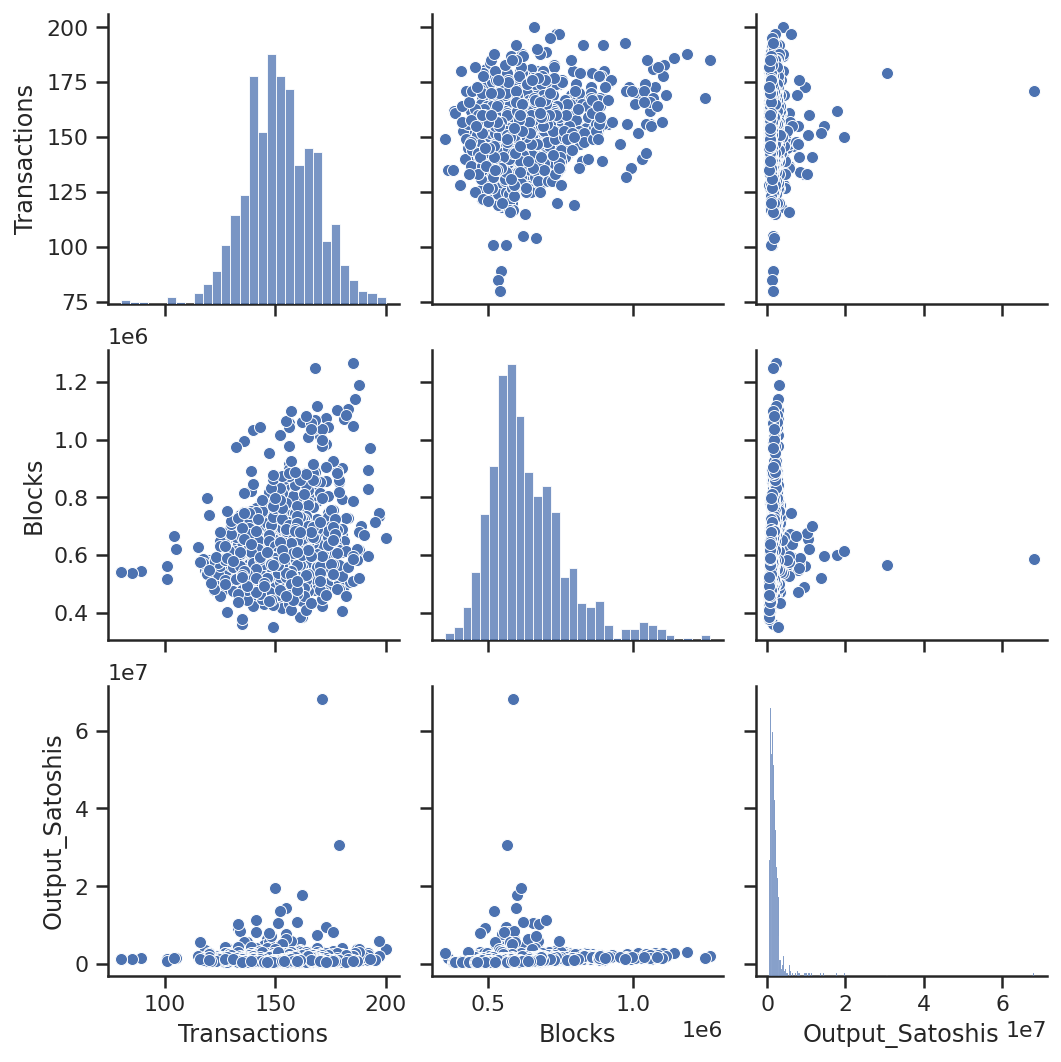

In [16]:
# check the relation among the features of data
sns.set(style="ticks")
sns.pairplot(result)

In [17]:
# select the three most important features (Transactions, Blocks, Output Satoshis) from the data
data = result[['Output_Satoshis','Blocks','Transactions']]
outliers_fraction=0.05
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 

IsolationForest(contamination=0.05)

Text(0.5, 0.92, 'Transactions vs Blocks vs Sum of Output Satoshis: Red represents Anomalies')

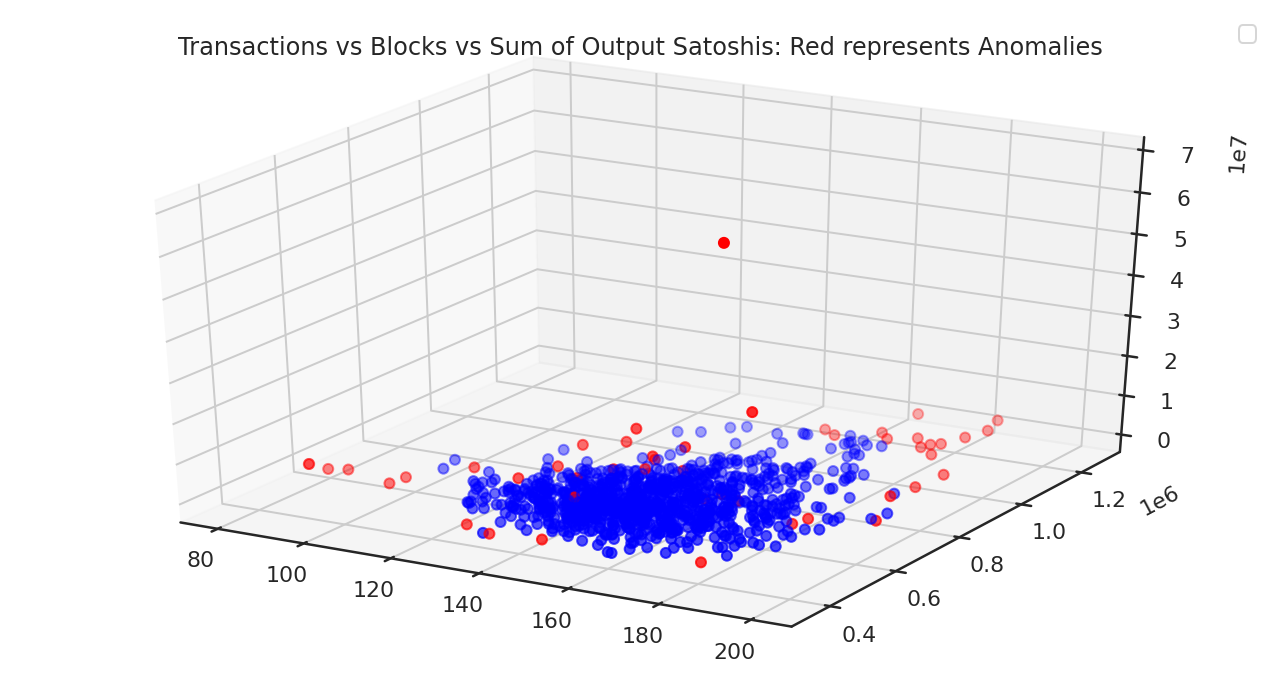

In [18]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111,projection='3d')
X = result.iloc[:,1:4].values
colors = np.array(['red', 'blue'])
y_pred = model.fit_predict(data)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=25, color=colors[(y_pred + 1) // 2] )
ax.legend()
#plt.xlabel('Transactions')
#plt.ylabel('Blocks')
#plt.zlabel('Sum of Output Satoshis')
plt.title('Transactions vs Blocks vs Sum of Output Satoshis: Red represents Anomalies')



The above plot cites Transactions, Features, Sum of Output Satoshis features to represents the anomalies in the data using the Isolation Forest method. Now, summarize the predictions just performed by assigning them binary values i.e., 0 or 1 (0 for normal, 1 for anomaly).

In [19]:
# create a new column for storing the results of Isolation Forest method
result['anomaly_IsolationForest'] = pd.Series(model.predict(data))
result['anomaly_IsolationForest'] = result['anomaly_IsolationForest'].apply(lambda x: x == -1)
result['anomaly_IsolationForest'] = result['anomaly_IsolationForest'].astype(int)
result['anomaly_IsolationForest'].value_counts()

0    924
1     49
Name: anomaly_IsolationForest, dtype: int64

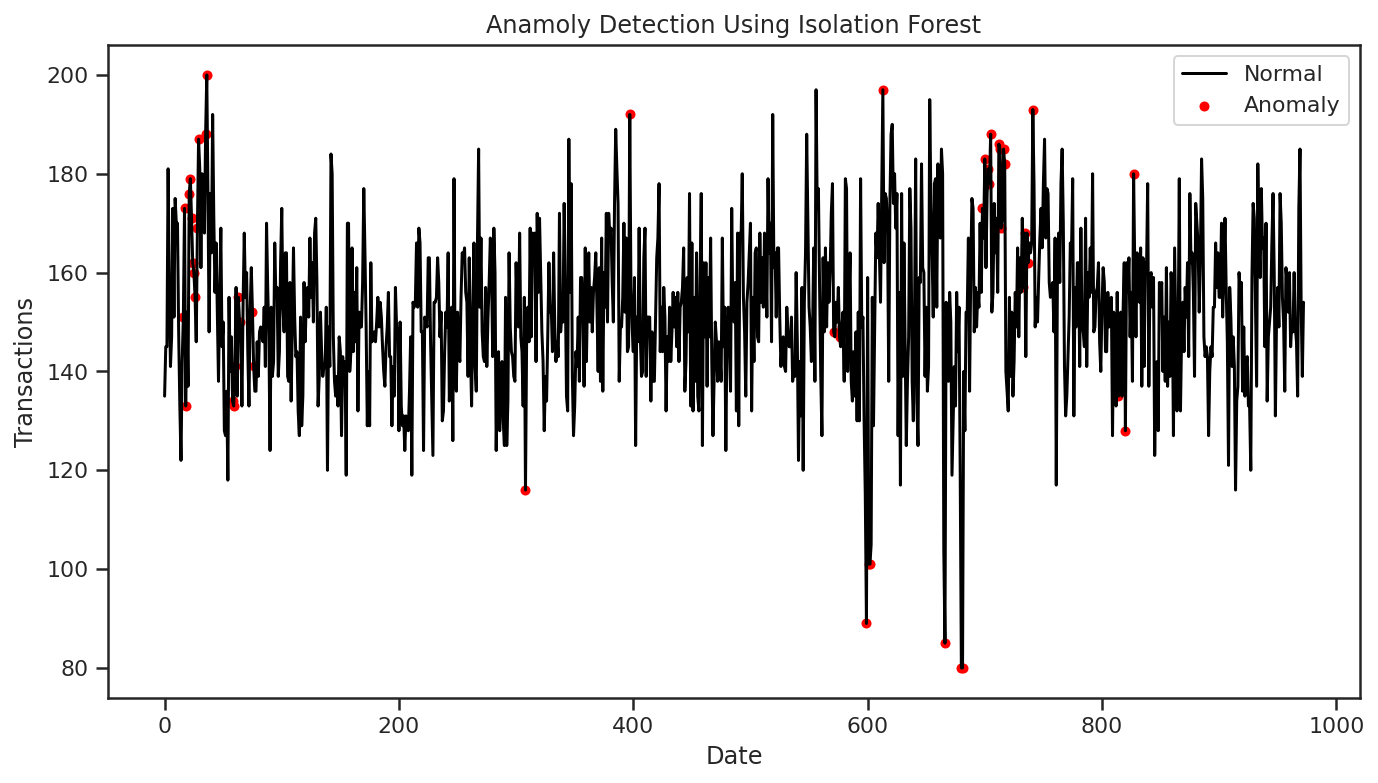

In [20]:
fig, ax = plt.subplots(figsize=(10,6))

#anomaly
a = result.loc[result['anomaly_IsolationForest'] == 1]
ax.plot(result['Transactions'], color='black', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Transactions'], color='red', label = 'Anomaly', s=16)
plt.legend()
plt.title("Anamoly Detection Using Isolation Forest")
plt.xlabel('Date')
plt.ylabel('Transactions')
#plt.savefig('IsolationForest_anomaly_Transactions.png', dpi=1000)
plt.show();


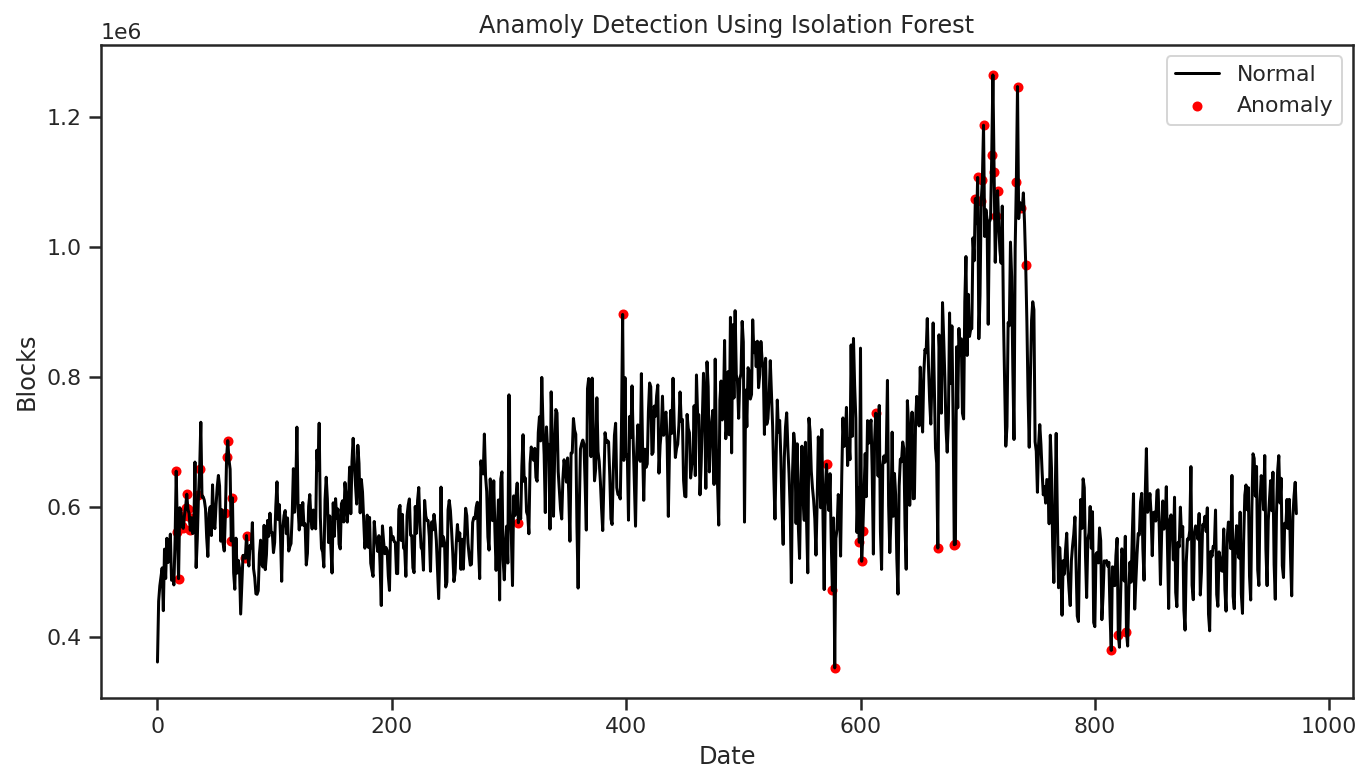

In [21]:
fig, ax = plt.subplots(figsize=(10,6))

#anomaly
a = result.loc[result['anomaly_IsolationForest'] == 1]
ax.plot(result['Blocks'], color='black', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Blocks'], color='red', label = 'Anomaly', s=16)
plt.legend()
plt.title("Anamoly Detection Using Isolation Forest")
plt.xlabel('Date')
plt.ylabel('Blocks')
#plt.savefig('IsolationForest_anomaly_Blocks.png', dpi=1000)
plt.show();

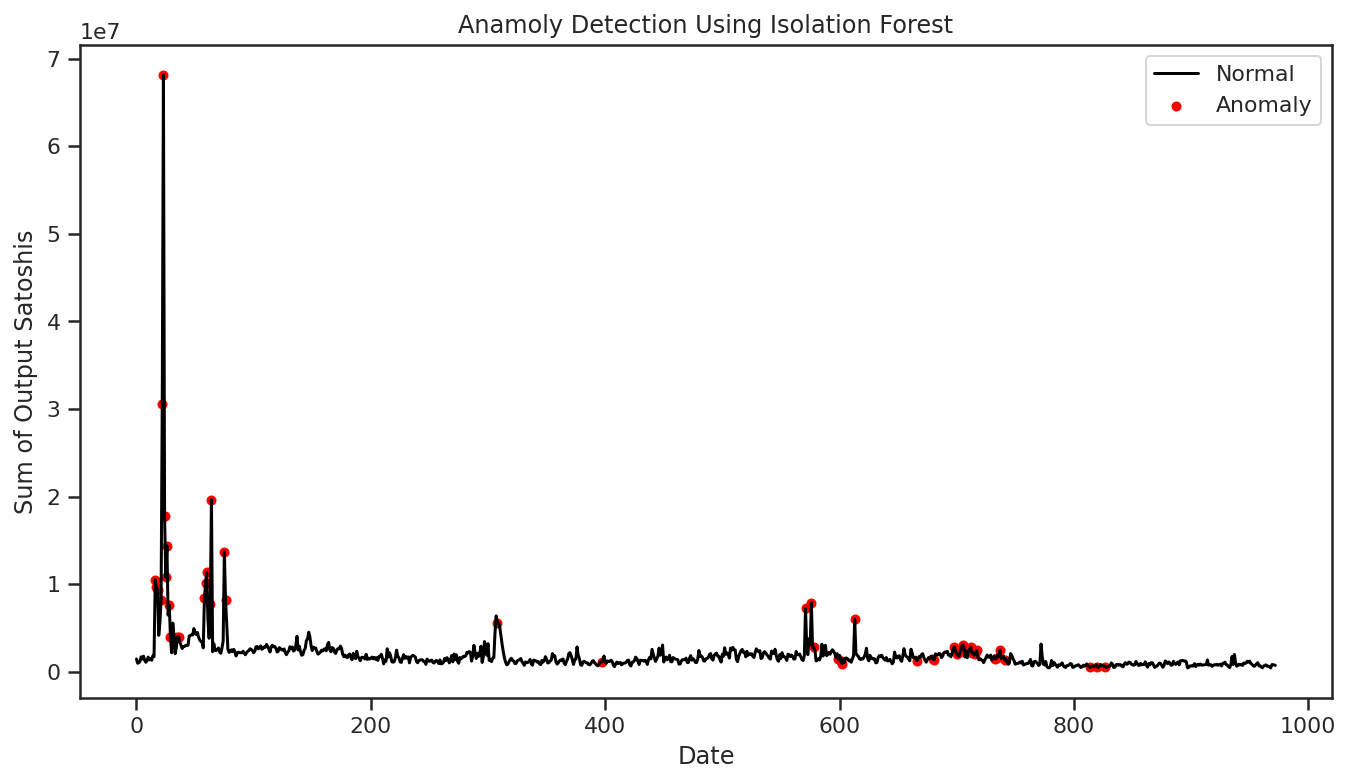

In [22]:
fig, ax = plt.subplots(figsize=(10,6))

#anomaly
a = result.loc[result['anomaly_IsolationForest'] == 1]
ax.plot(result['Output_Satoshis'], color='black', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Output_Satoshis'], color='red', label = 'Anomaly', s=16)
plt.legend()
plt.title("Anamoly Detection Using Isolation Forest")
plt.xlabel('Date')
plt.ylabel('Sum of Output Satoshis')
#plt.savefig('IsolationForest_anomaly_Output_Satoshis.png', dpi=1000)
plt.show();

We just inherited use of those three previous plots (Transactions, Blocks, Output Satoshis vs. date) for better understanding the Isolation Forest method predicted anomalies by visualizing them with outliers anomaly.

In [23]:
# This code has been taken from kernel https://github.com/anish-saha/EventDetection-Paradigm01/blob/master/KMeans.ipynb

def pca_results(good_data, pca):
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (10,10))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

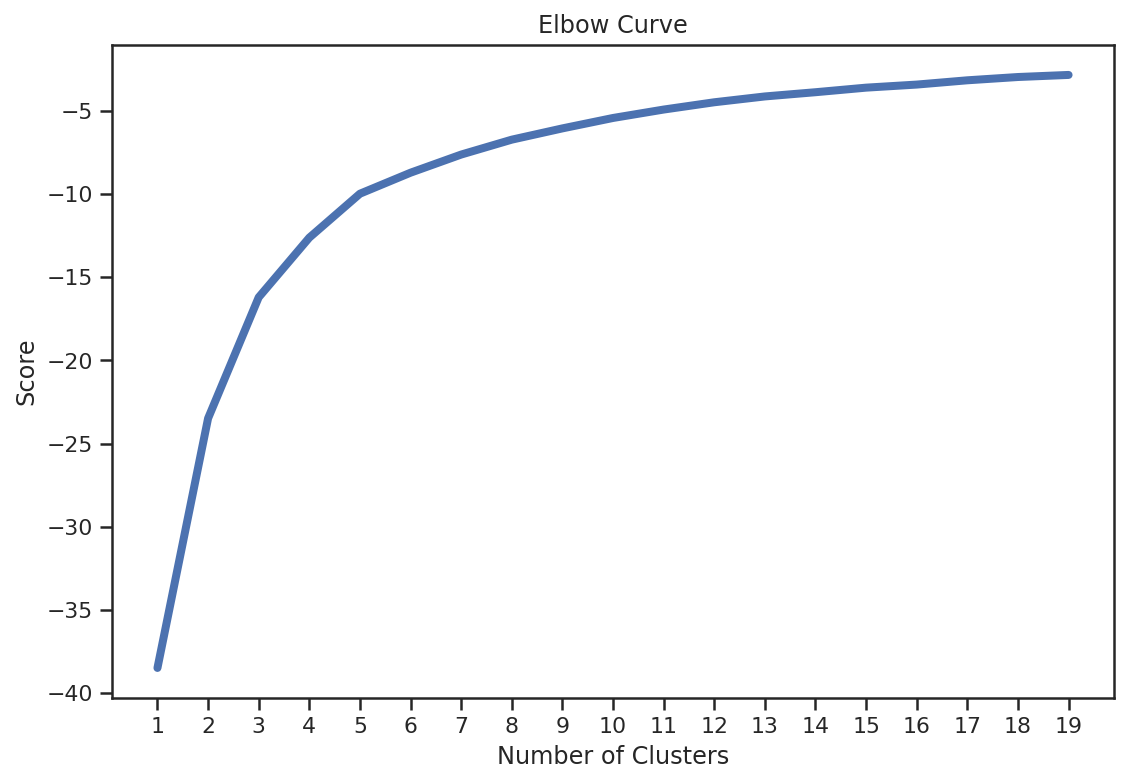

In [24]:
data_ = data.copy() # make a copy of data with three already selected features
data_ = data_.reset_index(drop=True)

data_[:] = MinMaxScaler().fit_transform(data_[:])
pca = PCA(n_components=2) # we have selected 2 components in PCA for simplicity
pca.fit(data_)
reduced_data = pca.transform(data_)
reduced_data = pd.DataFrame(reduced_data)

num_clusters = range(1, 20)

kmeans = [KMeans(n_clusters=i, random_state=seed).fit(reduced_data) for i in num_clusters]
scores = [kmeans[i].score(reduced_data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(num_clusters, scores, linewidth = 4)
plt.xticks(num_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

The above elbow-curve helps to determine the number of clusters for the K-means algorithm. The most drastic change recorded in the elbow-curve at 3 or 4 or 5 number of clusters. So let's which one of them is better for our case.

Explained Variance       0       1       2
Dimension 1              0.6132  0.0106  0.8225  0.5687
Dimension 2              0.3458 -0.0066  0.5688 -0.8224

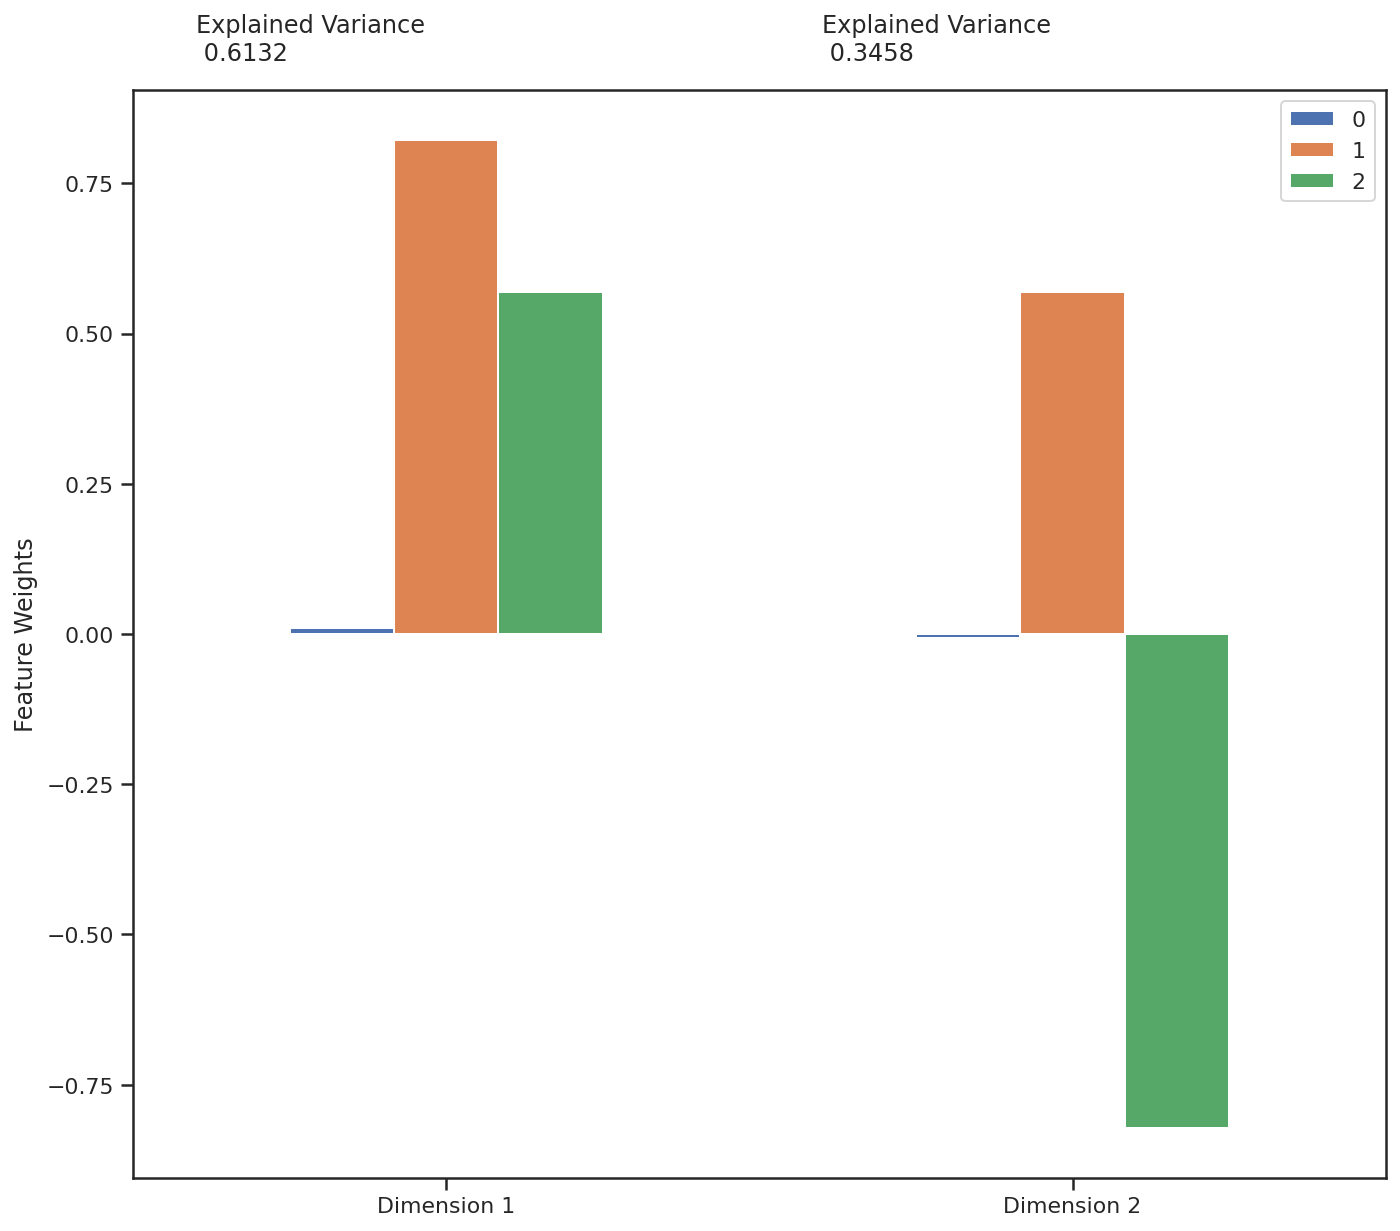

In [25]:
correlations = pd.DataFrame(data=data_).corr()
pca_results(correlations, pca)

In [26]:
#Choosing the three clusters based on the elbow curve
best_num_cluster__ = 3
km__ = KMeans(n_clusters=best_num_cluster__, random_state=seed)
km__.fit(reduced_data)
km__.predict(reduced_data)
labels__1 = km__.labels_

#Choosing the four clusters based on the elbow curve
best_num_cluster = 4
km = KMeans(n_clusters=best_num_cluster, random_state=seed)
km.fit(reduced_data)
km.predict(reduced_data)
labels = km.labels_

#Choosing the five clusters based on the elbow curve
best_num_cluster_ = 5
km_ = KMeans(n_clusters=best_num_cluster_, random_state=seed)
km_.fit(reduced_data)
km_.predict(reduced_data)
labels_1 = km_.labels_

<ipython-input-27-4f8ece83d3a9>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=labels__1.astype(np.float), edgecolor="k", s=16)


Text(0.5, 1.0, 'Clusters based on K means: 3 clusters')

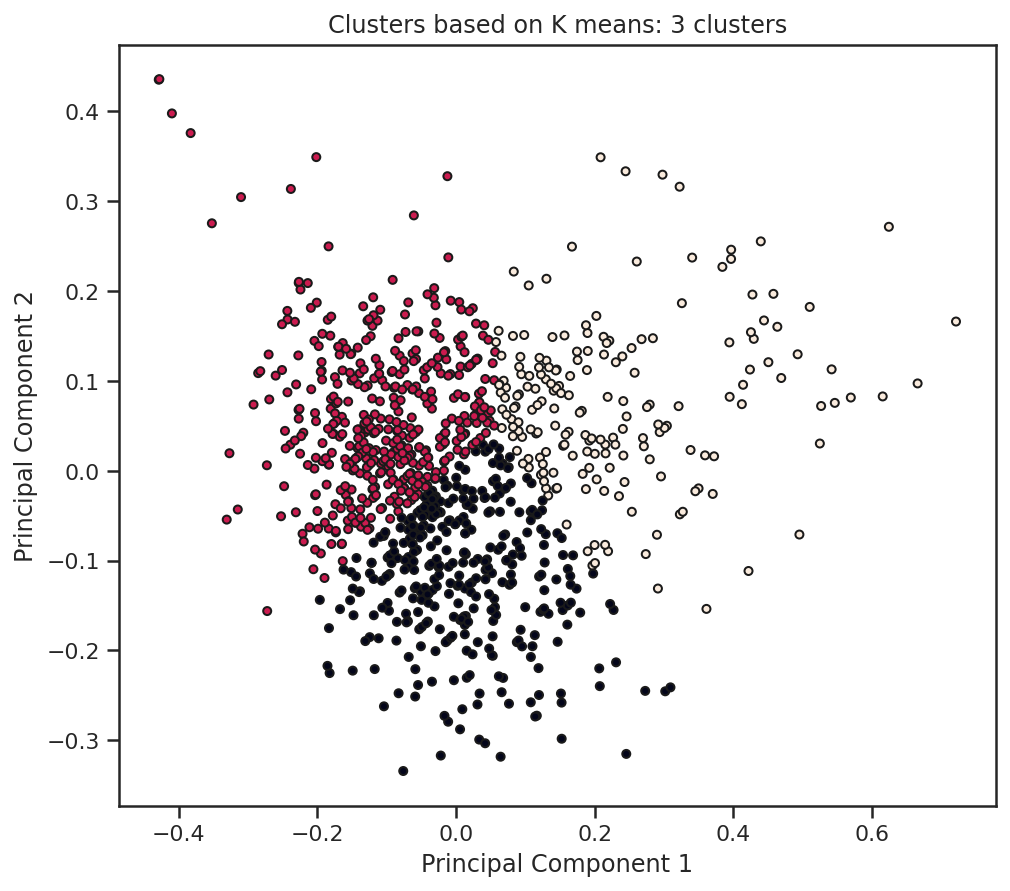

In [27]:
#Plotting based on three cluster
fig = plt.figure(1, figsize=(7,7))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], 
            c=labels__1.astype(np.float), edgecolor="k", s=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters based on K means: 3 clusters')

<ipython-input-28-e6d322cc91ed>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=labels.astype(np.float), edgecolor="k", s=16)


Text(0.5, 1.0, 'Clusters based on K means: 4 clusters')

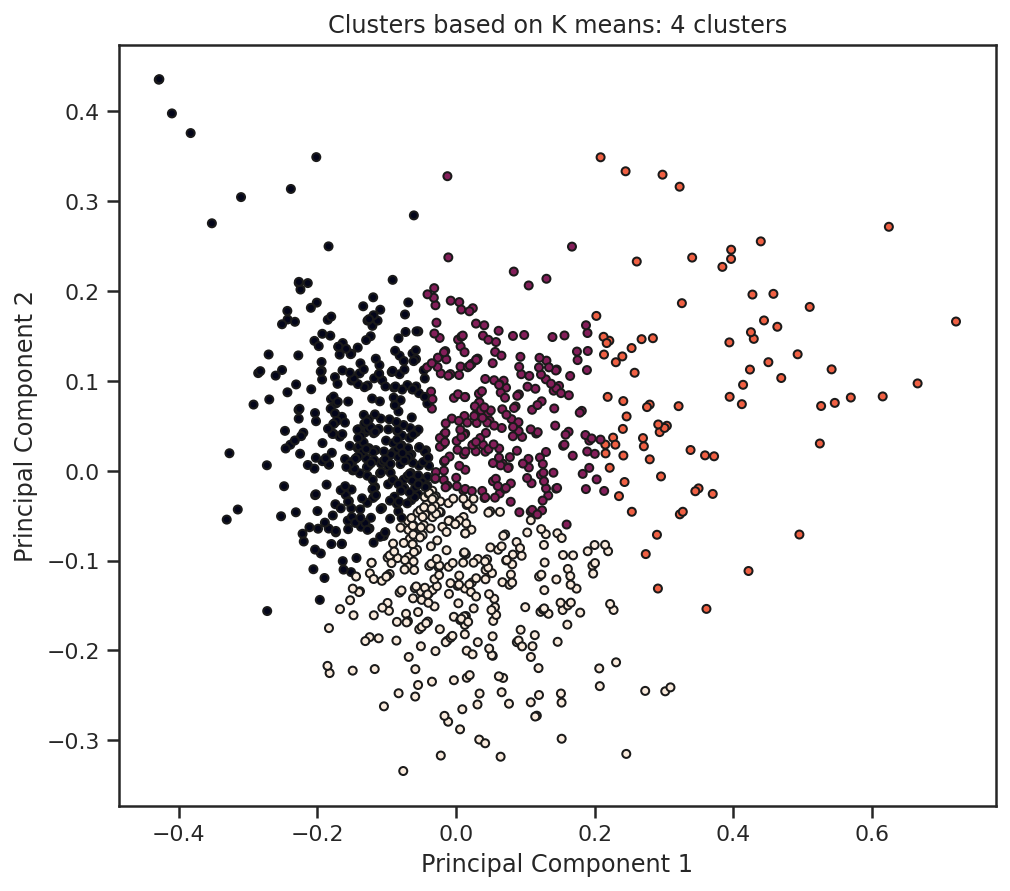

In [28]:
#Plotting based on four cluster
fig = plt.figure(1, figsize=(7,7))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], 
            c=labels.astype(np.float), edgecolor="k", s=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters based on K means: 4 clusters')

<ipython-input-29-21f16719621d>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=labels_1.astype(np.float), edgecolor="k", s=16)


Text(0.5, 1.0, 'Clusters based on K means: 5 clusters')

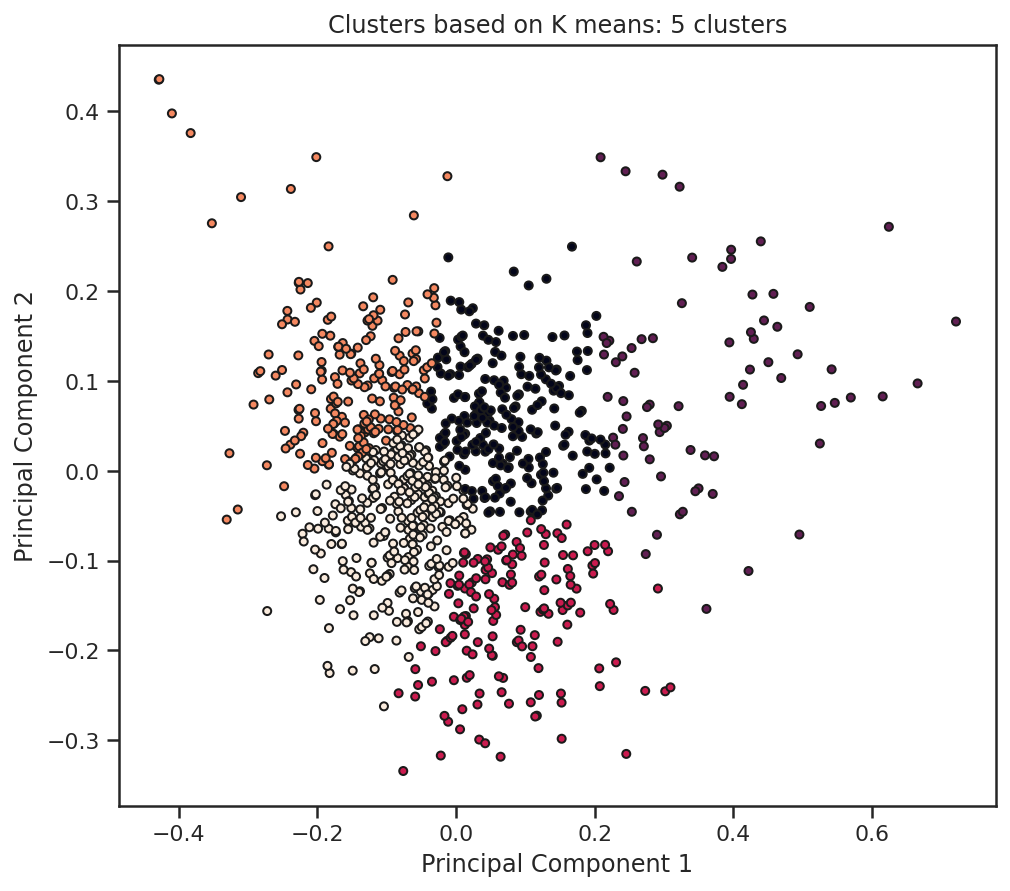

In [29]:
#Plotting based on five cluster
fig = plt.figure(1, figsize=(7,7))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], 
            c=labels_1.astype(np.float), edgecolor="k", s=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters based on K means: 5 clusters')

In [30]:
reduced_data.loc[0]
mod = kmeans[best_num_cluster-1]
mod.cluster_centers_

array([[-0.14041965,  0.04630001],
       [ 0.06590654,  0.06460244],
       [ 0.34854986,  0.0902566 ],
       [ 0.01180692, -0.13285169]])

In [31]:
reduced_data['Principal Component 1'] = reduced_data[0]
reduced_data['Principal Component 2'] = reduced_data[1]
reduced_data.drop(columns = [0, 1], inplace=True)
reduced_data.head()

Principal Component 1  Principal Component 2
0              -0.330545              -0.054375
1              -0.198850              -0.064509
2              -0.177580              -0.049808
3               0.005832              -0.287731
4              -0.095664              -0.114872

Text(0.5, 1.0, 'Anomaly prediction using KMeans: Red represents Anomaly')

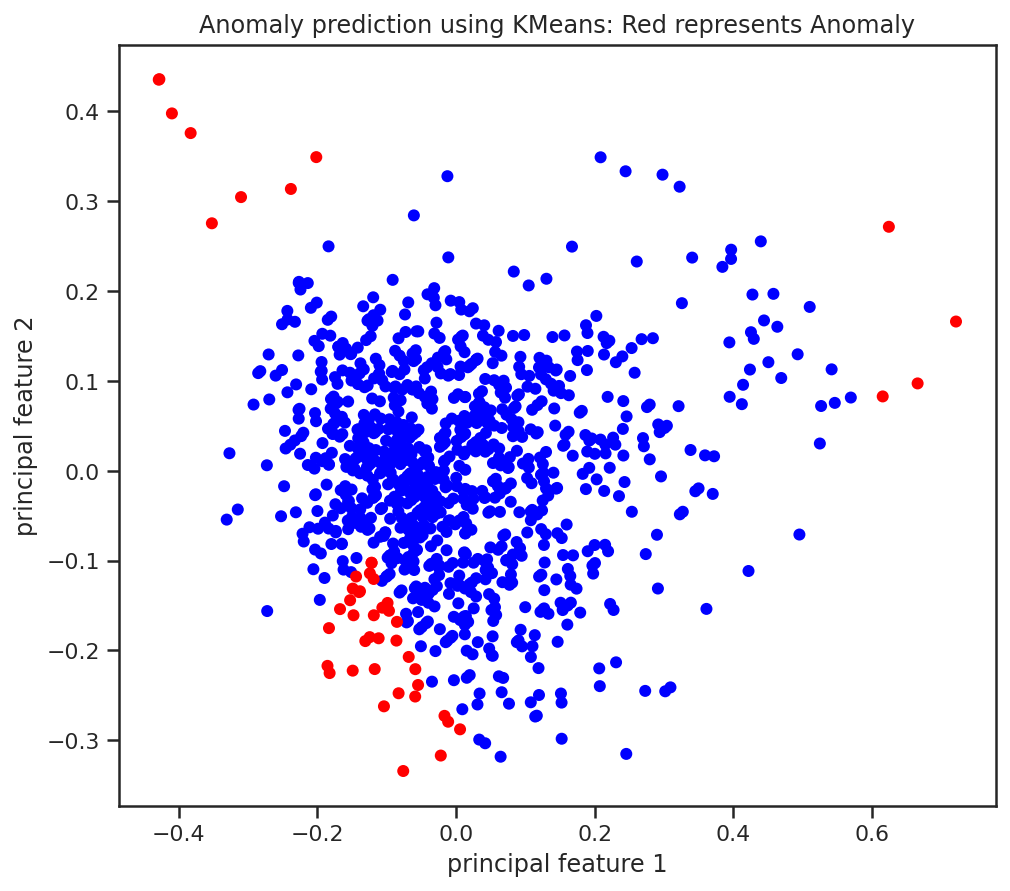

In [32]:
def getDistanceByPoint(data, model):
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return distance

outliers_fraction = 0.05
# find the distance between each point and its nearest centroid. The largest distances will be consdiered anomalies
distance = getDistanceByPoint(reduced_data, kmeans[best_num_cluster-1])
distance = pd.Series(distance)
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()


# anomaly_kmeans contain the anomaly result of the above method  (0:normal, 1:anomaly) 
result['anomaly_kmeans'] = (distance >= threshold).astype(int)

# visualisation of anomaly with cluster view
#fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
#colors = {1:'#f70505', 0:'#0a48f5'}
plt.figure(figsize=(7,7))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], 
            c=result["anomaly_kmeans"].apply(lambda x: colors[x]), s=25)
plt.xlabel('principal feature 1')
plt.ylabel('principal feature 2')
plt.title('Anomaly prediction using KMeans: Red represents Anomaly')
#plt.savefig('KMeans_anomaly.png', dpi=1000)

In [33]:
result['anomaly_kmeans'].value_counts()

0    925
1     48
Name: anomaly_kmeans, dtype: int64

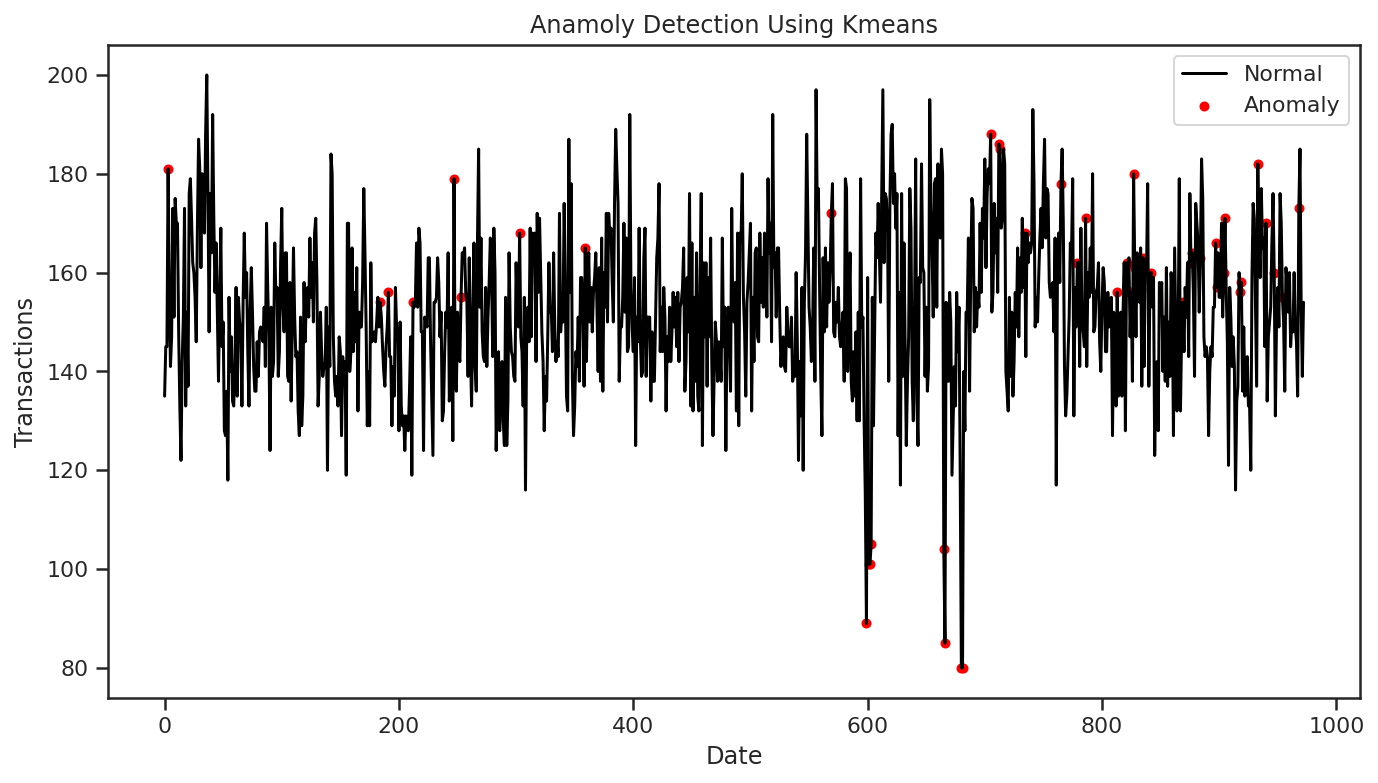

In [34]:
fig, ax = plt.subplots(figsize=(10,6))

#anomaly
a = result.loc[result['anomaly_kmeans'] == 1]
ax.plot(result['Transactions'], color='black', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Transactions'], color='red', label = 'Anomaly', s=16)
plt.legend()
plt.title("Anamoly Detection Using Kmeans")
plt.xlabel('Date')
plt.ylabel('Transactions')
#plt.savefig('KMeans_anomaly_Transactions.png', dpi=1000)
plt.show();

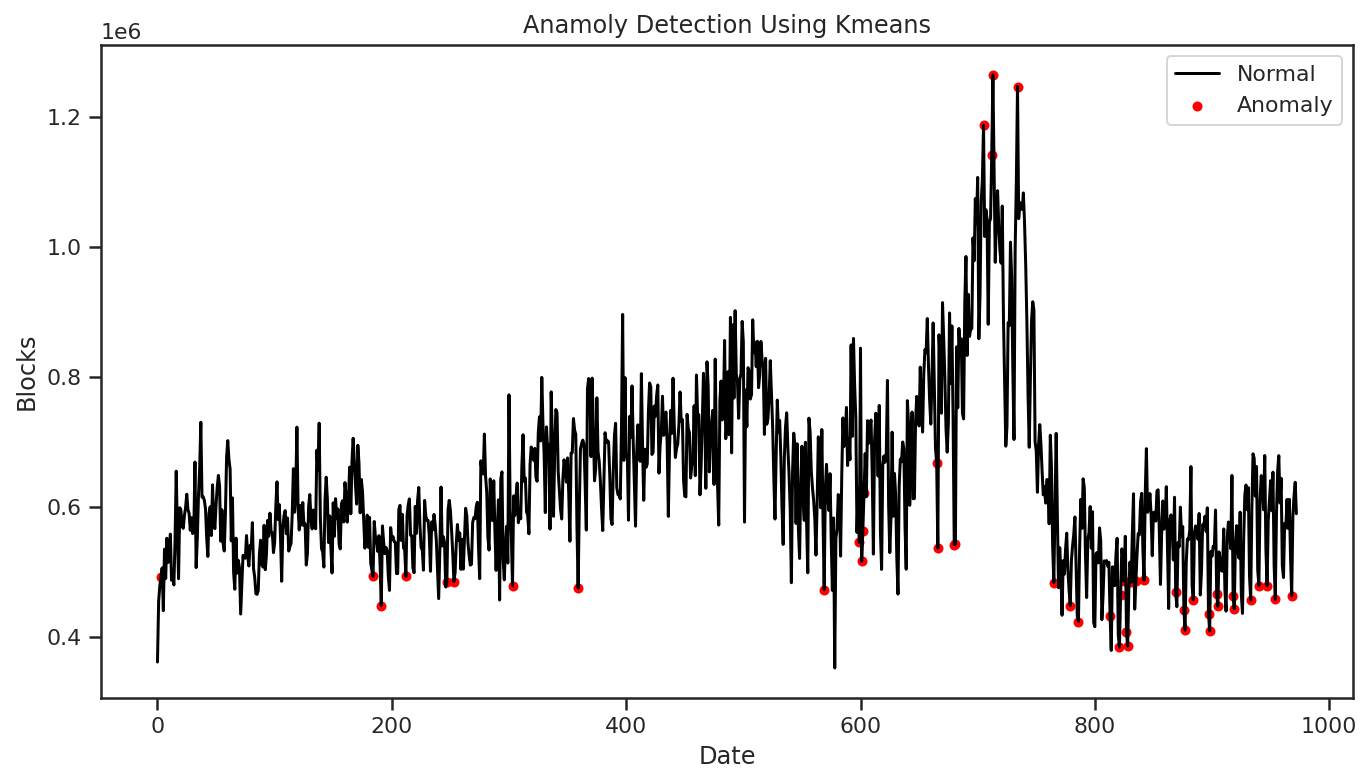

In [35]:
fig, ax = plt.subplots(figsize=(10,6))

#anomaly
a = result.loc[result['anomaly_kmeans'] == 1]
ax.plot(result['Blocks'], color='black', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Blocks'], color='red', label = 'Anomaly', s=16)
plt.legend()
plt.title("Anamoly Detection Using Kmeans")
plt.xlabel('Date')
plt.ylabel('Blocks')
#plt.savefig('KMeans_anomaly_Blocks.png', dpi=1000)
plt.show();

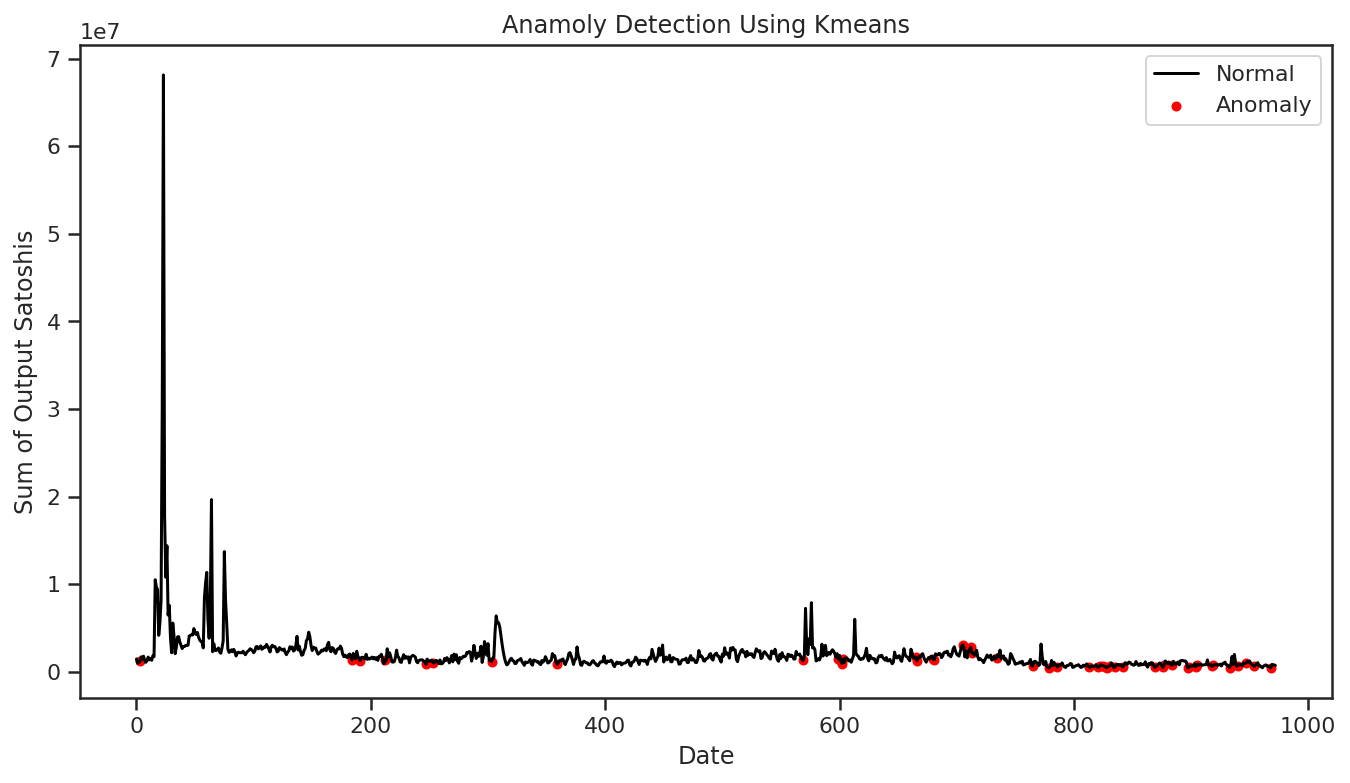

In [36]:
fig, ax = plt.subplots(figsize=(10,6))

#anomaly
a = result.loc[result['anomaly_kmeans'] == 1]
ax.plot(result['Output_Satoshis'], color='black', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Output_Satoshis'], color='red', label = 'Anomaly', s=16)
plt.legend()
plt.title("Anamoly Detection Using Kmeans")
plt.xlabel('Date')
plt.ylabel('Sum of Output Satoshis')
#plt.savefig('KMeans_anomaly_Output_Satoshis.png', dpi=1000)
plt.show();

In [37]:
# final result dataframe
result.head()

Date  Transactions  Blocks  Output_Satoshis  anomaly_IsolationForest  \
0  2016-01-01           135  361519     1.470216e+06                        0   
1  2016-01-02           145  455120     9.884226e+05                        0   
2  2016-01-03           145  478708     1.031215e+06                        0   
3  2016-01-04           181  492865     1.215813e+06                        0   
4  2016-01-05           157  506371     1.712227e+06                        0   

   anomaly_kmeans  
0               0  
1               0  
2               0  
3               1  
4               0

In [ ]:
result

Date  Transactions  Blocks  Output_Satoshis  \
0    2016-01-01           135  361519     1.470216e+06   
1    2016-01-02           145  455120     9.884226e+05   
2    2016-01-03           145  478708     1.031215e+06   
3    2016-01-04           181  492865     1.215813e+06   
4    2016-01-05           157  506371     1.712227e+06   
..          ...           ...     ...              ...   
968  2018-08-26           173  463319     4.437819e+05   
969  2018-08-27           185  585010     8.263798e+05   
970  2018-08-28           153  616972     8.239070e+05   
971  2018-08-29           139  638060     7.797214e+05   
972  2018-08-30           154  589764     7.347844e+05   

     anomaly_IsolationForest  anomaly_kmeans  
0                          1               0  
1                          0               0  
2                          0               0  
3                          0               1  
4                          0               0  
..                       ...             ...  
968                        0               1  
969                        0               0  
970                        0               0  
971                        0               0  
972                        0               0  

[973 rows x 6 columns]

In [38]:
# select the cases for final anomaly in which both the algorithms predicted anomaly
final_anomaly = result.query('anomaly_kmeans == 1 & anomaly_IsolationForest == 1')
final_anomaly.head()

Date  Transactions  Blocks  Output_Satoshis  \
599  2017-08-22            89  545685     1.465566e+06   
601  2017-08-24           101  516578     1.284993e+06   
602  2017-08-25           101  563269     9.364905e+05   
666  2017-10-28            85  536785     1.271140e+06   
680  2017-11-11            80  542026     1.414263e+06   

     anomaly_IsolationForest  anomaly_kmeans  
599                        1               1  
601                        1               1  
602                        1               1  
666                        1               1  
680                        1               1

In [39]:
# Select the cases in which either of the two algorithms predicted anomaly
possible_anomaly = result.query('anomaly_kmeans == 1 | anomaly_IsolationForest == 1')
possible_anomaly.head()

Date  Transactions  Blocks  Output_Satoshis  \
3   2016-01-04           181  492865     1.215813e+06   
16  2016-01-17           151  655229     1.051440e+07   
17  2016-01-18           173  561828     9.670702e+06   
18  2016-01-19           133  489778     9.396367e+06   
21  2016-01-22           176  570236     8.180728e+06   

    anomaly_IsolationForest  anomaly_kmeans  
3                         0               1  
16                        1               0  
17                        1               0  
18                        1               0  
21                        1               0

In [40]:
# Select the cases where no algorithm predicted anomaly
no_anomaly = result.query('anomaly_kmeans == 0 & anomaly_IsolationForest == 0')
no_anomaly.head()

Date  Transactions  Blocks  Output_Satoshis  anomaly_IsolationForest  \
0  2016-01-01           135  361519     1.470216e+06                        0   
1  2016-01-02           145  455120     9.884226e+05                        0   
2  2016-01-03           145  478708     1.031215e+06                        0   
4  2016-01-05           157  506371     1.712227e+06                        0   
5  2016-01-06           141  440544     1.463102e+06                        0   

   anomaly_kmeans  
0               0  
1               0  
2               0  
4               0  
5               0

In [41]:
total_anomaly = len(final_anomaly)+len(possible_anomaly)
percent_total_anomaly = total_anomaly*100/len(result)
print('Total records:',len(result))
print('Number of final anomaly:', len(final_anomaly))
print('Number of possible anomaly:', len(possible_anomaly))
print('Total anomaly:', total_anomaly)
print('Percentage of total anomaly in the data: %0.2f' % percent_total_anomaly)

Total records: 973
Number of final anomaly: 11
Number of possible anomaly: 86
Total anomaly: 97
Percentage of total anomaly in the data: 9.97


In [42]:
reduced_data.head()
mod = kmeans[best_num_cluster-1]
mod.cluster_centers_

array([[-0.14041965,  0.04630001],
       [ 0.06590654,  0.06460244],
       [ 0.34854986,  0.0902566 ],
       [ 0.01180692, -0.13285169]])

In [43]:
reduced_data["labels"] = km.labels_
sample_data = reduced_data.sample(n=100)
reduced_data["fd_labels"] = sample_data["labels"].astype(int)
reduced_data.head()

Principal Component 1  Principal Component 2  labels  fd_labels
0              -0.330545              -0.054375       0        NaN
1              -0.198850              -0.064509       0        NaN
2              -0.177580              -0.049808       0        NaN
3               0.005832              -0.287731       3        NaN
4              -0.095664              -0.114872       3        NaN

<ipython-input-44-d2c8f6bbb9ac>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.scatter(sample_data.iloc[:,0], sample_data.iloc[:,1], c=sample_data["labels"].astype(np.float),edgecolor="white", s=16)


Text(0, 0.5, 'Principal Component 2')

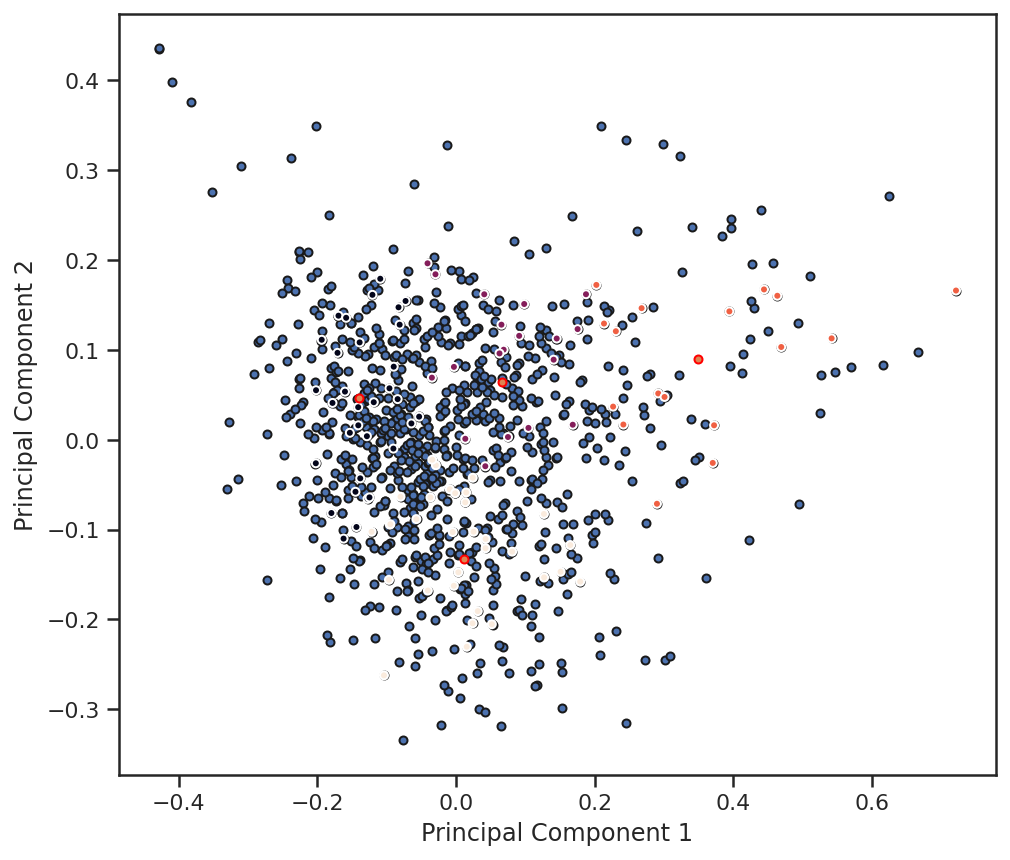

In [44]:
#Plotting based on three cluster
fig = plt.figure(1, figsize=(7,7))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], edgecolor="k", s=16)
plt.scatter(sample_data.iloc[:,0], sample_data.iloc[:,1], c=sample_data["labels"].astype(np.float),edgecolor="white", s=16)
plt.scatter(mod.cluster_centers_[:,0], mod.cluster_centers_[:,1], edgecolor="red", s=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.title('Clusters based on K means: 3 clusters')

In [45]:
def fractal_dimension(df):
  min_x, max_x = np.min(df[:, 0]), np.max(df[:, 0])
  min_y, max_y = np.min(df[:, 1]), np.max(df[:, 1])

  boxes = range(1, int(min(max_x - min_x, max_y - min_y)/2), 2)
  #print(boxes)
  count = []
  for box in boxes:
      count_box = 0
      for i in range(min_x, max_x, box):
          for j in range(min_y, max_y, box):
              if np.sum(np.logical_and(df[:, 0] >= i, df[:, 0] < i + box) &
                        np.logical_and(df[:, 1] >= j, df[:, 1] < j + box)) > 0:
                  count_box += 1
      count.append(count_box)

  # Plot box counting results
  # plt.plot(np.log(boxes), np.log(count))
  # plt.xlabel('log(box size)')
  # plt.ylabel('log(number of boxes)')
  # plt.show()

  # Calculate fractal dimension as slope of the line
  slope, intercept = np.polyfit(np.log(boxes), np.log(count), 1)
  fractal_dim = -slope
  print(fractal_dim)
  return fractal_dim

In [46]:
init_0 = np.array((reduced_data[reduced_data["fd_labels"] == 0].iloc[:,0:2]*100).astype(int))
init_1 = np.array((reduced_data[reduced_data["fd_labels"] == 1].iloc[:,0:2]*100).astype(int))
init_2 = np.array((reduced_data[reduced_data["fd_labels"] == 2].iloc[:,0:2]*100).astype(int))
init_3 = np.array((reduced_data[reduced_data["fd_labels"] == 3].iloc[:,0:2]*100).astype(int))



prev_fd_0 = fractal_dimension(init_0)
prev_fd_1 = fractal_dimension(init_1)
prev_fd_2 = fractal_dimension(init_2)
prev_fd_3 = fractal_dimension(init_3)




0.4078898855159968
0.3547779393963372
0.22097120180072147
0.5352306690267512


In [47]:
reduced_data.at[0, "fd_labels"] == 0

False

In [48]:
np.array((reduced_data[reduced_data["fd_labels"] == 0].iloc[:,0:2]*1000).astype(int))

array([[-120,  161],
       [-109,  179],
       [-144,  -57],
       [-138,  -42],
       [ -64,   18],
       [-124,  -64],
       [ -89,   81],
       [ -53,   25],
       [-138,  108],
       [-193,  111],
       [ -90,   -9],
       [-162, -110],
       [ -95,   57],
       [-178,   40],
       [ -81,  128],
       [-128,    3],
       [ -84,   45],
       [-118,   41],
       [ -82,  147],
       [ -72,  154],
       [-169,  138],
       [-170,   96],
       [-140,   16],
       [-179,  -81],
       [-201,   55],
       [-127,  -65],
       [-153,    7],
       [-158,  135],
       [-141,   36],
       [-143,  -97],
       [-202,  -26],
       [-160,   53]])

In [49]:
for index, row in reduced_data.iterrows():
  print(index)
  if row.fd_labels:
    newrow = np.array((row[0:2]*100).astype(int))
    new_fd_0 = fractal_dimension(np.vstack([init_0, newrow]))
    new_fd_1 = fractal_dimension(np.vstack([init_1, newrow]))
    new_fd_2 = fractal_dimension(np.vstack([init_2, newrow]))
    new_fd_3 = fractal_dimension(np.vstack([init_3, newrow]))

    min_diff = min(abs(prev_fd_0-new_fd_0), abs(prev_fd_1-new_fd_1), abs(prev_fd_2-new_fd_2), abs(prev_fd_3-new_fd_3))
    print(min_diff)
    if abs(prev_fd_0-new_fd_0) == min_diff:
      print("In 0")
      init_0 = np.vstack([init_0, newrow])
      prev_fd_0 = new_fd_0
      reduced_data.at[index, "fd_labels"] = 0
    elif abs(prev_fd_1-new_fd_1) == min_diff:
      print("In 1")
      init_1 = np.vstack([init_1, newrow])
      prev_fd_1 = new_fd_1
      reduced_data.at[index, "fd_labels"] = 1
    elif abs(prev_fd_2-new_fd_2) == min_diff:
      print("In 2")
      init_2 = np.vstack([init_2, newrow])
      prev_fd_2 = new_fd_2
      reduced_data.at[index, "fd_labels"] = 2
    elif abs(prev_fd_3-new_fd_3) == min_diff:
      print("In 3")
      init_3 = np.vstack([init_3, newrow])
      prev_fd_3 = new_fd_3
      reduced_data.at[index, "fd_labels"] =3



Streaming output truncated to the last 5000 lines.
0.96232310384911
0.0
In 3
242
0.6500028088292927
0.7383117996109626
0.3819861371631335
0.965752230095532
0.0034291262464219985
In 3
243
0.46697754242201517
0.7363168499431628
0.38281787649068694
1.0373135490906746
0.004477546568388835
In 1
244
0.46697754242201517
0.740738073676349
0.3710583068617146
1.0154688887946688
0.0
In 2
245
0.45870516976865044
0.7431457705160472
0.3819861371631335
0.965752230095532
0.0
In 3
246
0.576191349846512
0.7431457705160472
0.39937454273827777
1.0259566110573528
0.006828920572884423
In 1
247
0.4151003300892881
0.8391229291686358
0.48343543759254104
0.9696074839048777
0.0038552538093457045
In 3
248
249
0.4678446122831596
0.7475120707937994
0.3819861371631335
1.0543174376927191
0.0043663002777522
In 1
250
0.46697754242201517
0.752227350317254
0.38281787649068694
0.9696074839048777
0.0
In 3
251
0.46697754242201517
0.7537878245824221
0.3781993088635087
1.0262008436689771
0.006275753788622662
In 1
252
0.466977

In [50]:
reduced_data["fd_labels"].value_counts()

1.0    482
3.0    329
0.0     82
2.0     80
Name: fd_labels, dtype: int64

<ipython-input-51-22e163a654d5>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1],c=reduced_data["fd_labels"].astype(np.float),  edgecolor="k", s=16)


Text(0, 0.5, 'Principal Component 2')

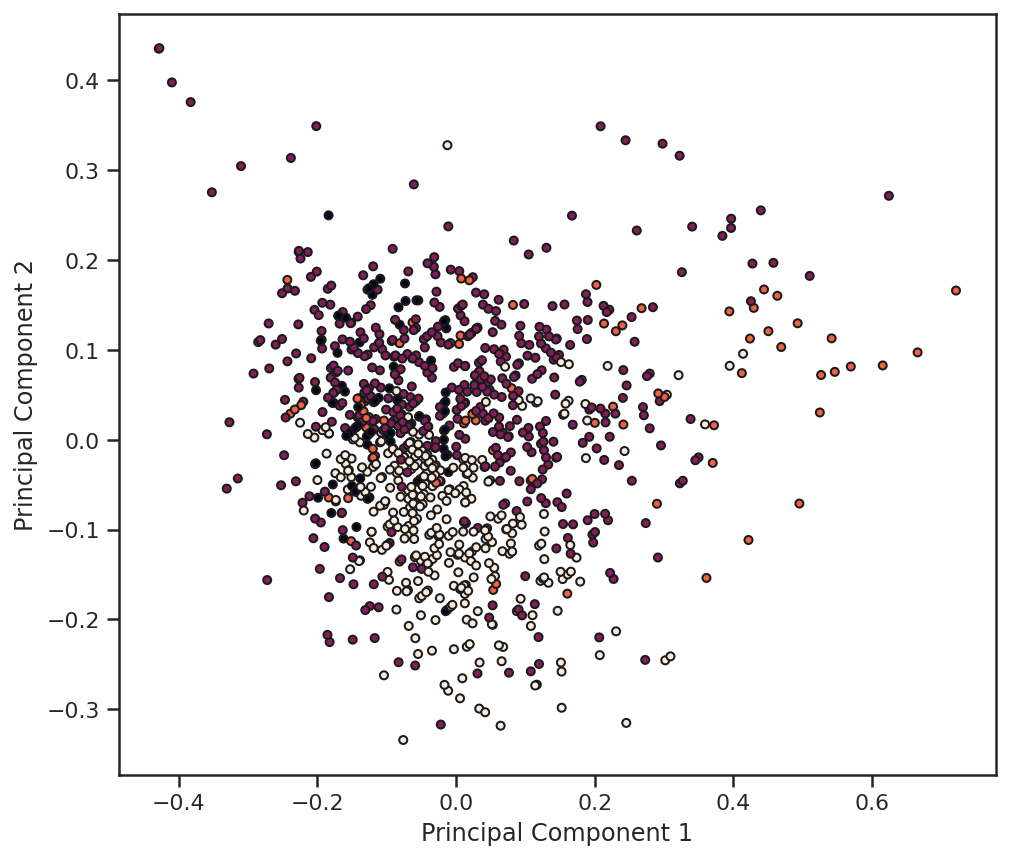

In [51]:
fig = plt.figure(1, figsize=(7,7))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1],c=reduced_data["fd_labels"].astype(np.float),  edgecolor="k", s=16)
#plt.scatter(sample_data.iloc[:,0], sample_data.iloc[:,1], c=sample_data["fd_labels"].astype(np.float),edgecolor="k", s=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.title('Clusters based on K means: 3 clusters')

# Conclusion

Hence, we have determined 76 possible anomalies in the last three years (i.e., 10 percent anomaly) of Google BigQuery Bitcoin Blockchain dataset. We have utilized two popular anomaly detection methods: Isolation Forest and K-Means. The notable fact obtained from the results is that both anomaly detection methods predicts 38 anomaly cases, which is reasonably consistent. We can further explore the anomaly detection in blockchain systems by utilizing more data or including other features. Lastly, anomaly detection tools can be effectively used to make the blockchain systems even stronger and safer by automatically recognizing and filtering out anomalous activities.